* This notebook was made to look at when currents from cold start could catch up with nowcasts, so that I can determine how many days before that I could run a simulation use TS initial file rather than restart file, to do the hindcast of Oct8-10, 2014. Is 1 day before that enough to catch the UV velocity with nowcasts? The answer will be explored in this notebook.

In [1]:
from __future__ import division, print_function

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from glob import glob
from salishsea_tools.nowcast import figures
from salishsea_tools.nowcast import analyze
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

* First I would like to have a look at currents comparison between Doug's nowcasts and my new river treatment results. It should have discrepency all the time.

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77,##426 start from 349 fortran start from 350
        'j' : 34,##293 start from 259 fortran start from 260
    },
    }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '20', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '18'}

* For June 15

In [3]:
grid_T_15 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_T.nc')

In [4]:
grid_U_new15 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/24nor_NW/15jun15/SalishSea_1h_20150615_20150615_grid_U.nc')
grid_V_new15 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/24nor_NW/15jun15/SalishSea_1h_20150615_20150615_grid_V.nc')

In [5]:
u_15new = grid_U_new15.variables['vozocrtx']
v_15new = grid_V_new15.variables['vomecrty']

In [6]:
grid_U_15 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_U.nc')
grid_V_15 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_V.nc')

In [7]:
u_15now = grid_U_15.variables['vozocrtx']
v_15now = grid_V_15.variables['vomecrty']

In [8]:
def compare_surfacecurrent_new(grid_T, PST, u_15new, v_15new, u_15now, v_15now):
    '''This function was made to compare surface currents at Sandheads
        during a day'''
    ##some constant parameters
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_final, t = figures.get_model_time_variables(grid_T)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    fig = plt.figure(figsize=(35,15))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
    gs.update(wspace=0.13,hspace=0.25)
    ax0 = fig.add_subplot(gs[0, 0])  # U for new & nowcasts
    ax1 = fig.add_subplot(gs[1, 0])  # V for new & nowcasts
    ax2 = fig.add_subplot(gs[0, 1])  # difference for U
    ax3 = fig.add_subplot(gs[1, 1])  # difference for V
    axs = [ax0, ax1]
    axss = [ax2,ax3]
    names = ['Sandheads']
    uv_new = [u_15new, v_15new]
    uv_now = [u_15now, v_15now]
    labels = 'new'
    labelss = 'nowcast'
    
    for iuv, ax in zip(uv_new, axs):
        if t_orig.day < 16:
            ii =  iuv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259] 
        else:
            ii= iuv[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']]
        ax.plot(t,ii,linewidth=2, label = labels)
        ax.grid('on')
        ax.set_ylim([-2,1.5])
        ax.set_title(
            'Hourly Surface Current at '+ names[0]+' :{t_orig:%d-%b-%Y}'
            .format( t_orig=t_orig),
            **title_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.legend(loc = 3,fontsize = 18)
    ax0.set_ylabel('zonal surface current u (m/s)', **axis_font)

    for juv, ax in zip(uv_now, axs): ## uv for nowcasts
        jj =  juv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,jj,linestyle='--' ,linewidth=2, label= labelss)
        ax.grid('on')
        ax.legend(loc = 3, fontsize = 18)
    ax1.set_ylabel('meridional surface current v (m/s)', **axis_font)
    
    for new, now, ax in zip(uv_new, uv_now, axss):
        if t_orig.day < 16:
            ii =  new[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259] -\
            now[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        else:
            ii= new[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']] -\
            now[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,ii,color = 'k',linewidth=2)
        ax.grid('on')
        ax.set_ylim([-1,1])
        ax.set_title(
            'Currents difference at '+ names[0]+' : {t_orig:%d-%b-%Y}'
                .format( t_orig=t_orig),
                **title_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_ylabel('difference of currents (m/s)', **axis_font)  
    
    return fig   

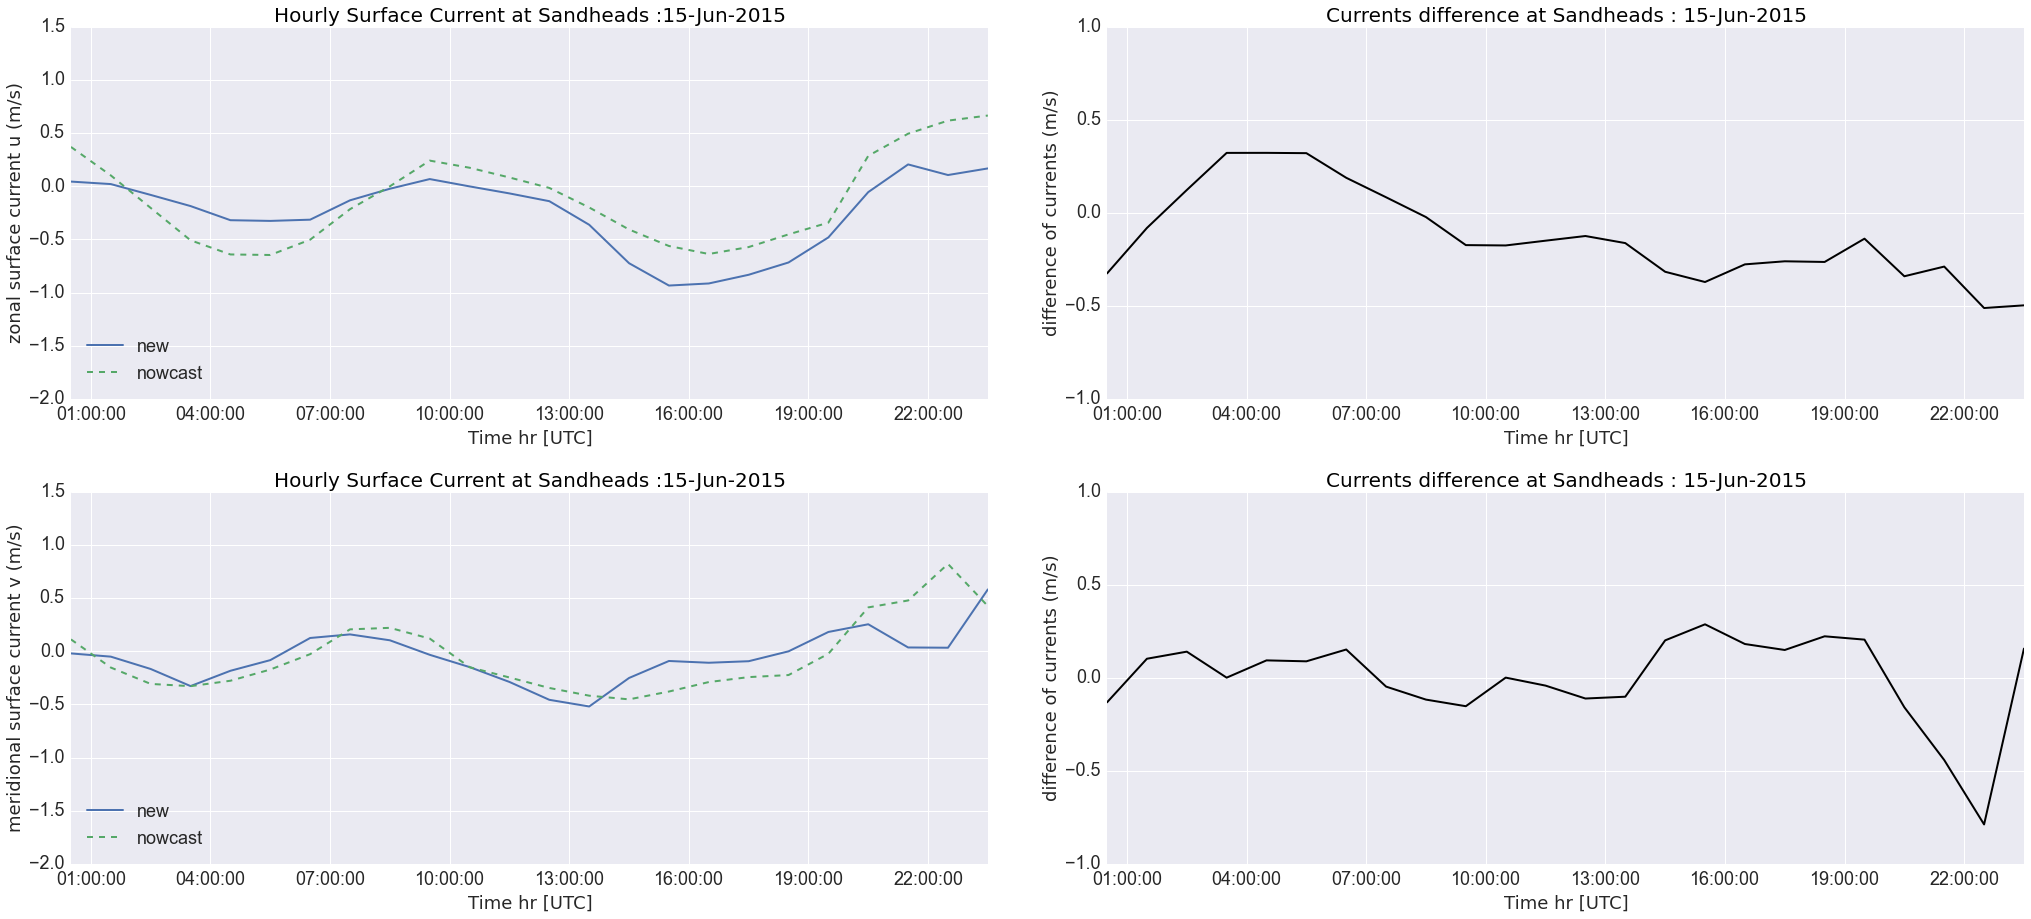

In [9]:
fig = compare_surfacecurrent_new(grid_T_15, 0, u_15new, v_15new, u_15now, v_15now)

* For June 16 

In [11]:
grid_T_16 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/16jun15/SalishSea_1h_20150616_20150616_grid_T.nc')

In [12]:
grid_U_new16 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150616_20150616_grid_U.nc')
grid_V_new16 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150616_20150616_grid_V.nc')

In [13]:
u_16new = grid_U_new16.variables['vozocrtx']
v_16new = grid_V_new16.variables['vomecrty']

In [14]:
grid_U_16 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/16jun15/SalishSea_1h_20150616_20150616_grid_U.nc')
grid_V_16 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/16jun15/SalishSea_1h_20150616_20150616_grid_V.nc')

In [15]:
u_16now = grid_U_16.variables['vozocrtx']
v_16now = grid_V_16.variables['vomecrty']

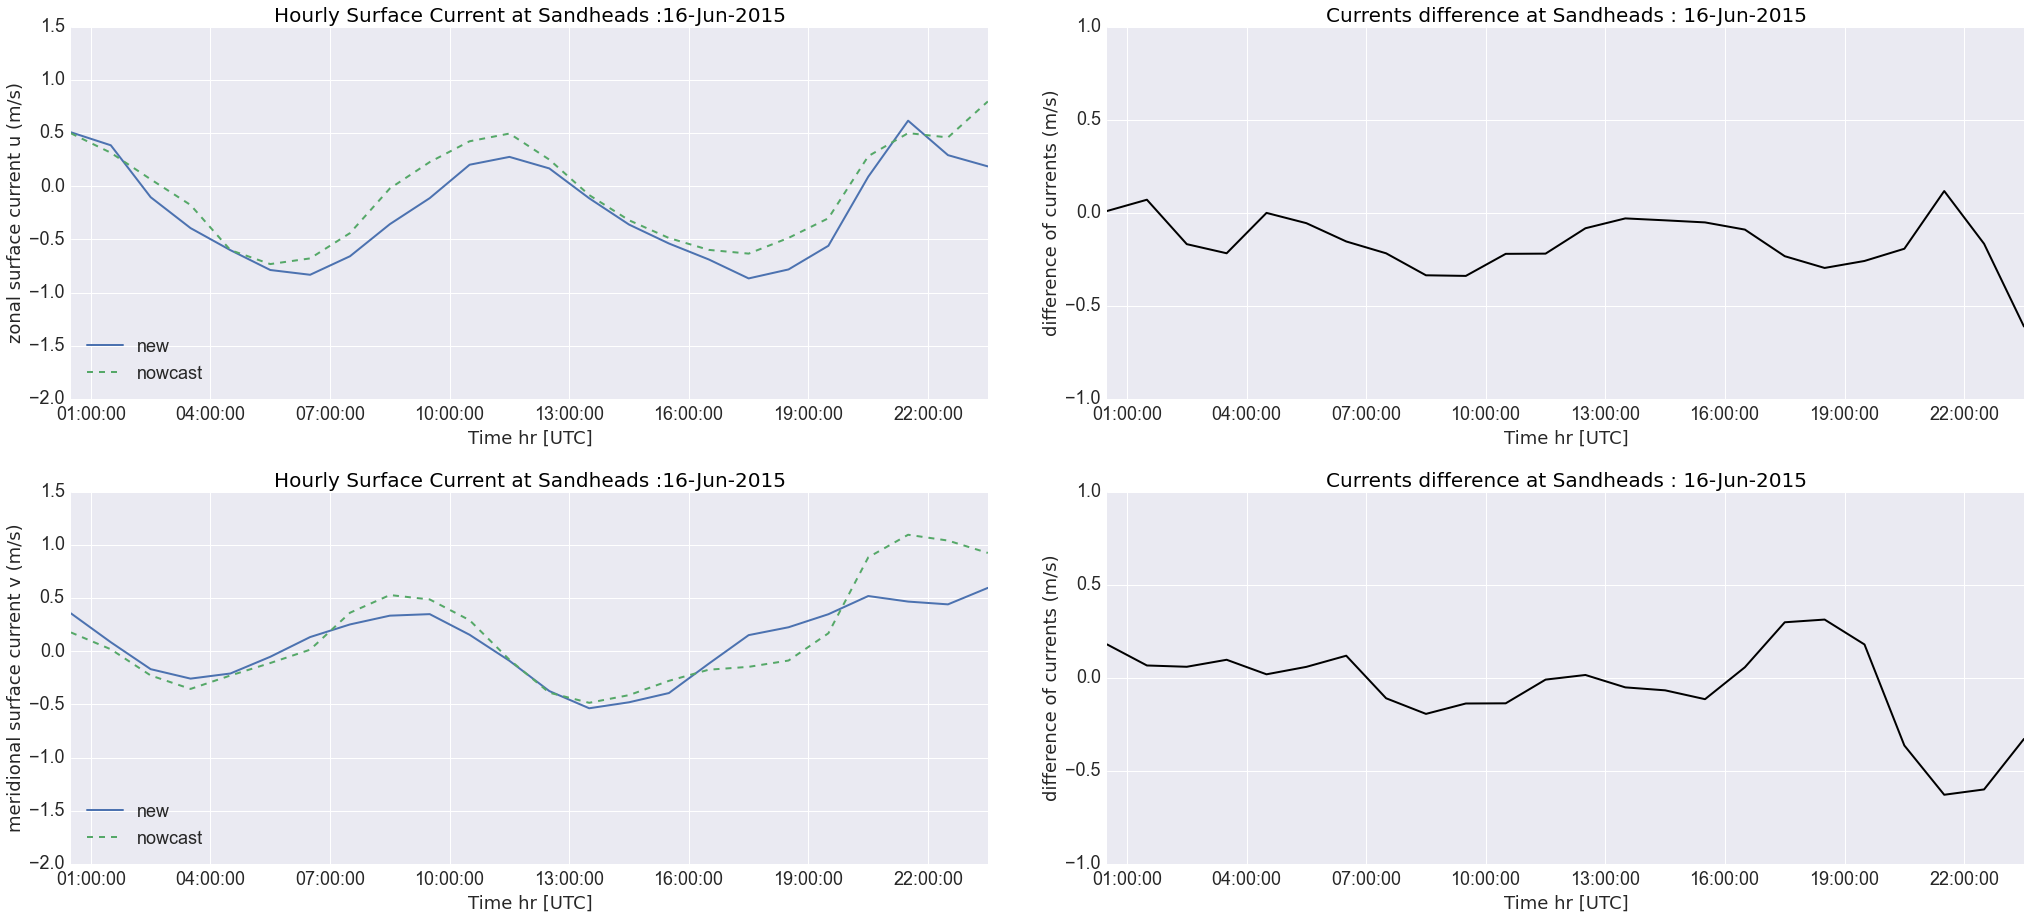

In [16]:
fig = compare_surfacecurrent_new(grid_T_16,0, u_16new, v_16new, u_16now, v_16now)

* For June 17

In [17]:
grid_T_17 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/17jun15/SalishSea_1h_20150617_20150617_grid_T.nc')

In [18]:
grid_U_new17 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150617_20150617_grid_U.nc')
grid_V_new17 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150617_20150617_grid_V.nc')

In [19]:
u_17new = grid_U_new17.variables['vozocrtx']
v_17new = grid_V_new17.variables['vomecrty']

In [20]:
grid_U_17 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/17jun15/SalishSea_1h_20150617_20150617_grid_U.nc')
grid_V_17 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/17jun15/SalishSea_1h_20150617_20150617_grid_V.nc')

In [21]:
u_17now = grid_U_17.variables['vozocrtx']
v_17now = grid_V_17.variables['vomecrty']

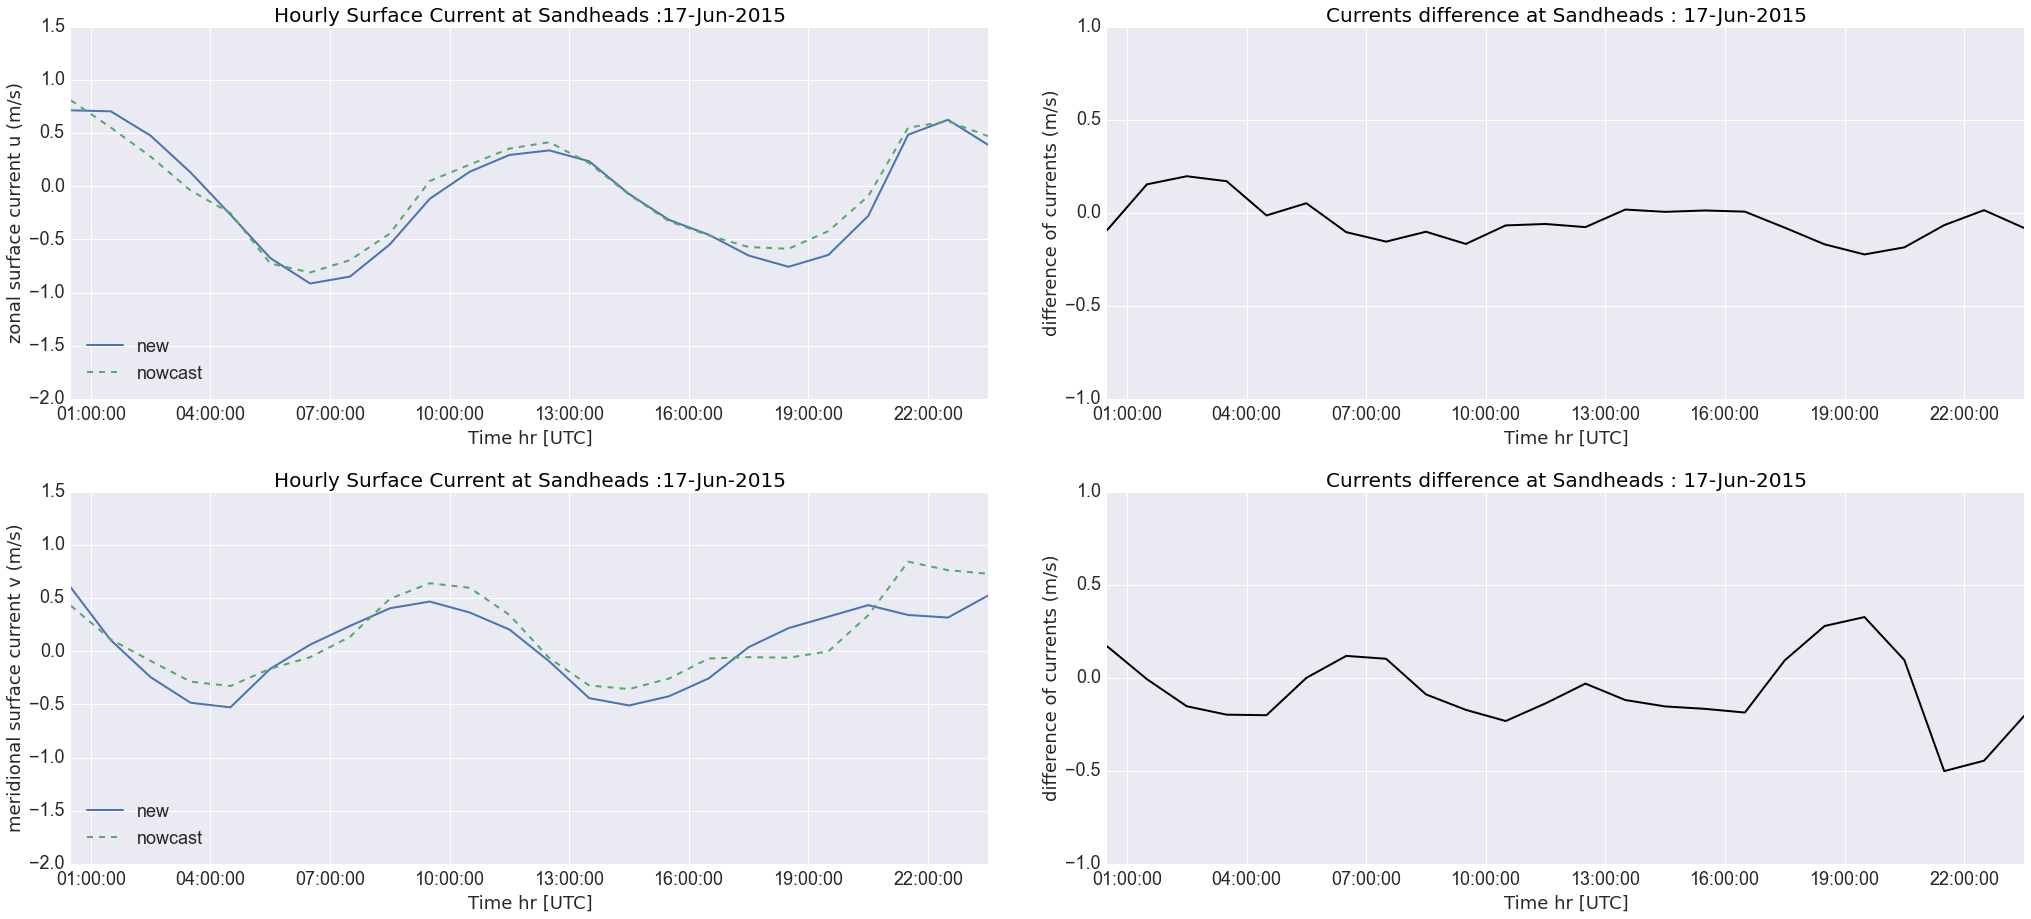

In [22]:
fig = compare_surfacecurrent_new(grid_T_17,0, u_17new, v_17new, u_17now, v_17now)

* For June 18

In [23]:
grid_T_18 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/18jun15/SalishSea_1h_20150618_20150618_grid_T.nc')
grid_U_new18 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150618_20150618_grid_U.nc')
grid_V_new18 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150618_20150618_grid_V.nc')
u_18new = grid_U_new18.variables['vozocrtx']
v_18new = grid_V_new18.variables['vomecrty']
grid_U_18 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/18jun15/SalishSea_1h_20150618_20150618_grid_U.nc')
grid_V_18 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/18jun15/SalishSea_1h_20150618_20150618_grid_V.nc')
u_18now = grid_U_18.variables['vozocrtx']
v_18now = grid_V_18.variables['vomecrty']

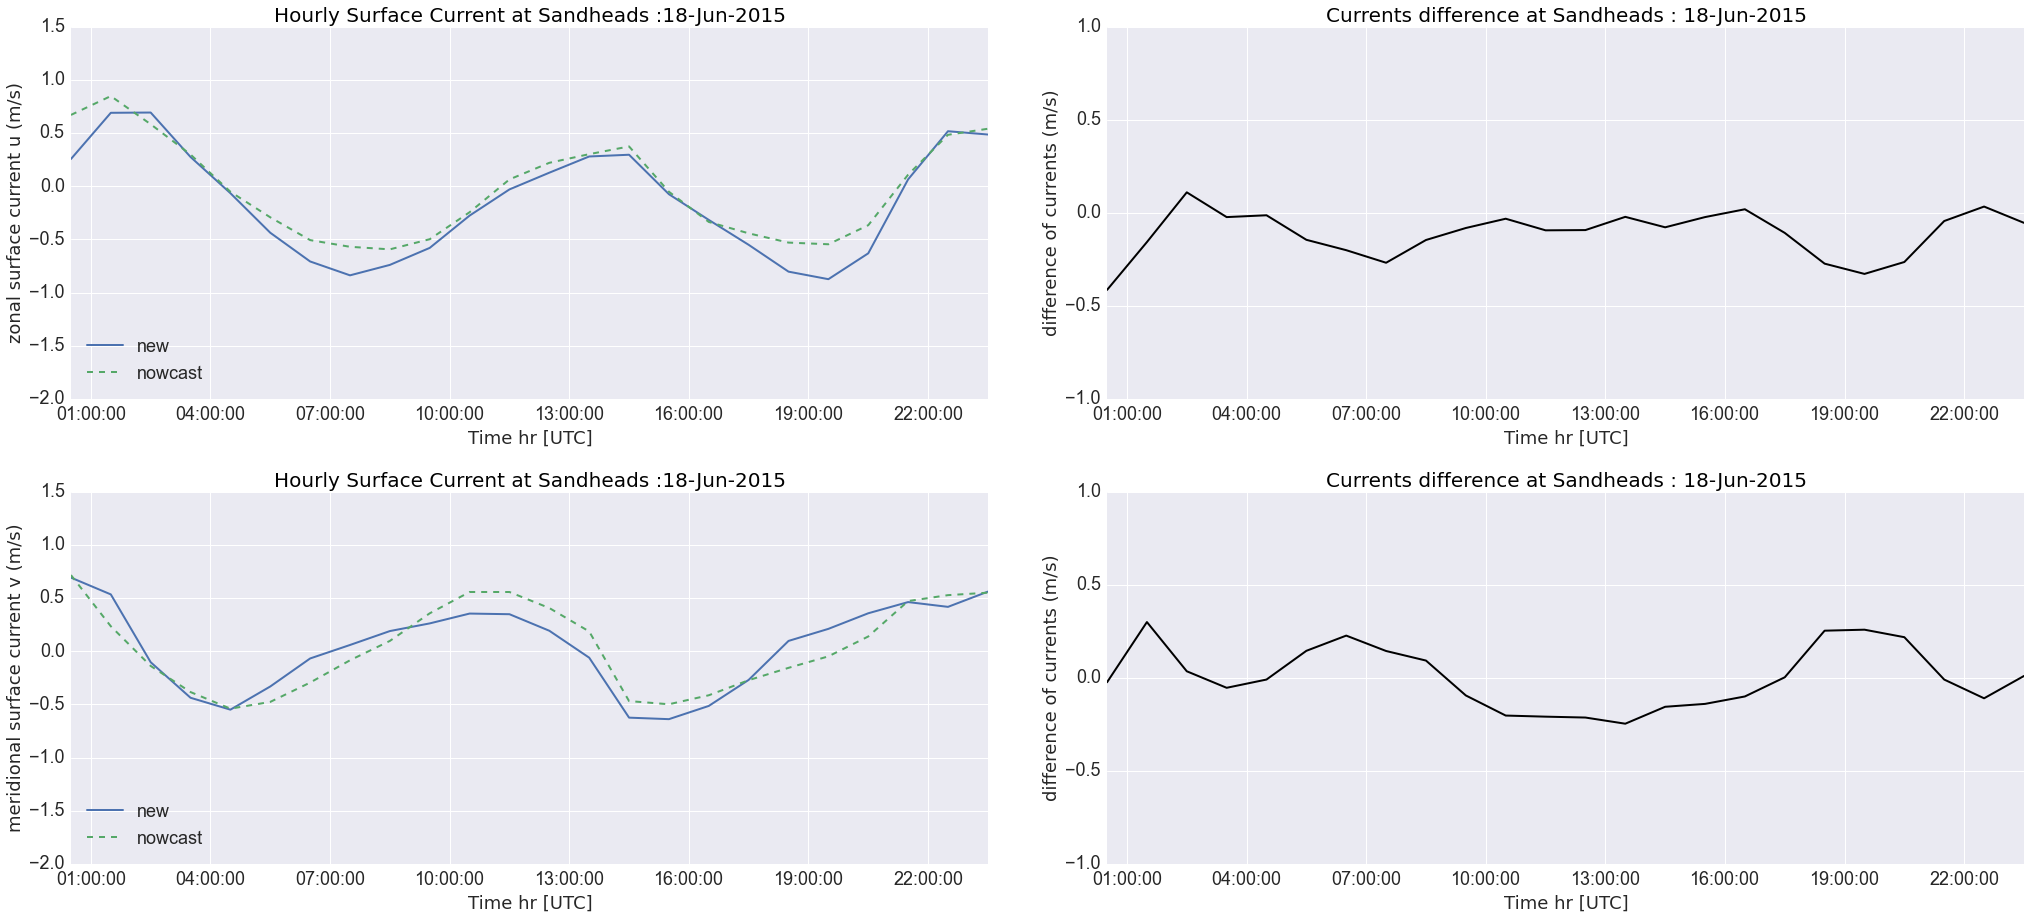

In [24]:
fig = compare_surfacecurrent_new(grid_T_18,0, u_18new, v_18new, u_18now, v_18now)

* For June 19

In [25]:
grid_T_19 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/19jun15/SalishSea_1h_20150619_20150619_grid_T.nc')
grid_U_new19 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150619_20150619_grid_U.nc')
grid_V_new19 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150619_20150619_grid_V.nc')
u_19new = grid_U_new19.variables['vozocrtx']
v_19new = grid_V_new19.variables['vomecrty']
grid_U_19 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/19jun15/SalishSea_1h_20150619_20150619_grid_U.nc')
grid_V_19 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/19jun15/SalishSea_1h_20150619_20150619_grid_V.nc')
u_19now = grid_U_19.variables['vozocrtx']
v_19now = grid_V_19.variables['vomecrty']

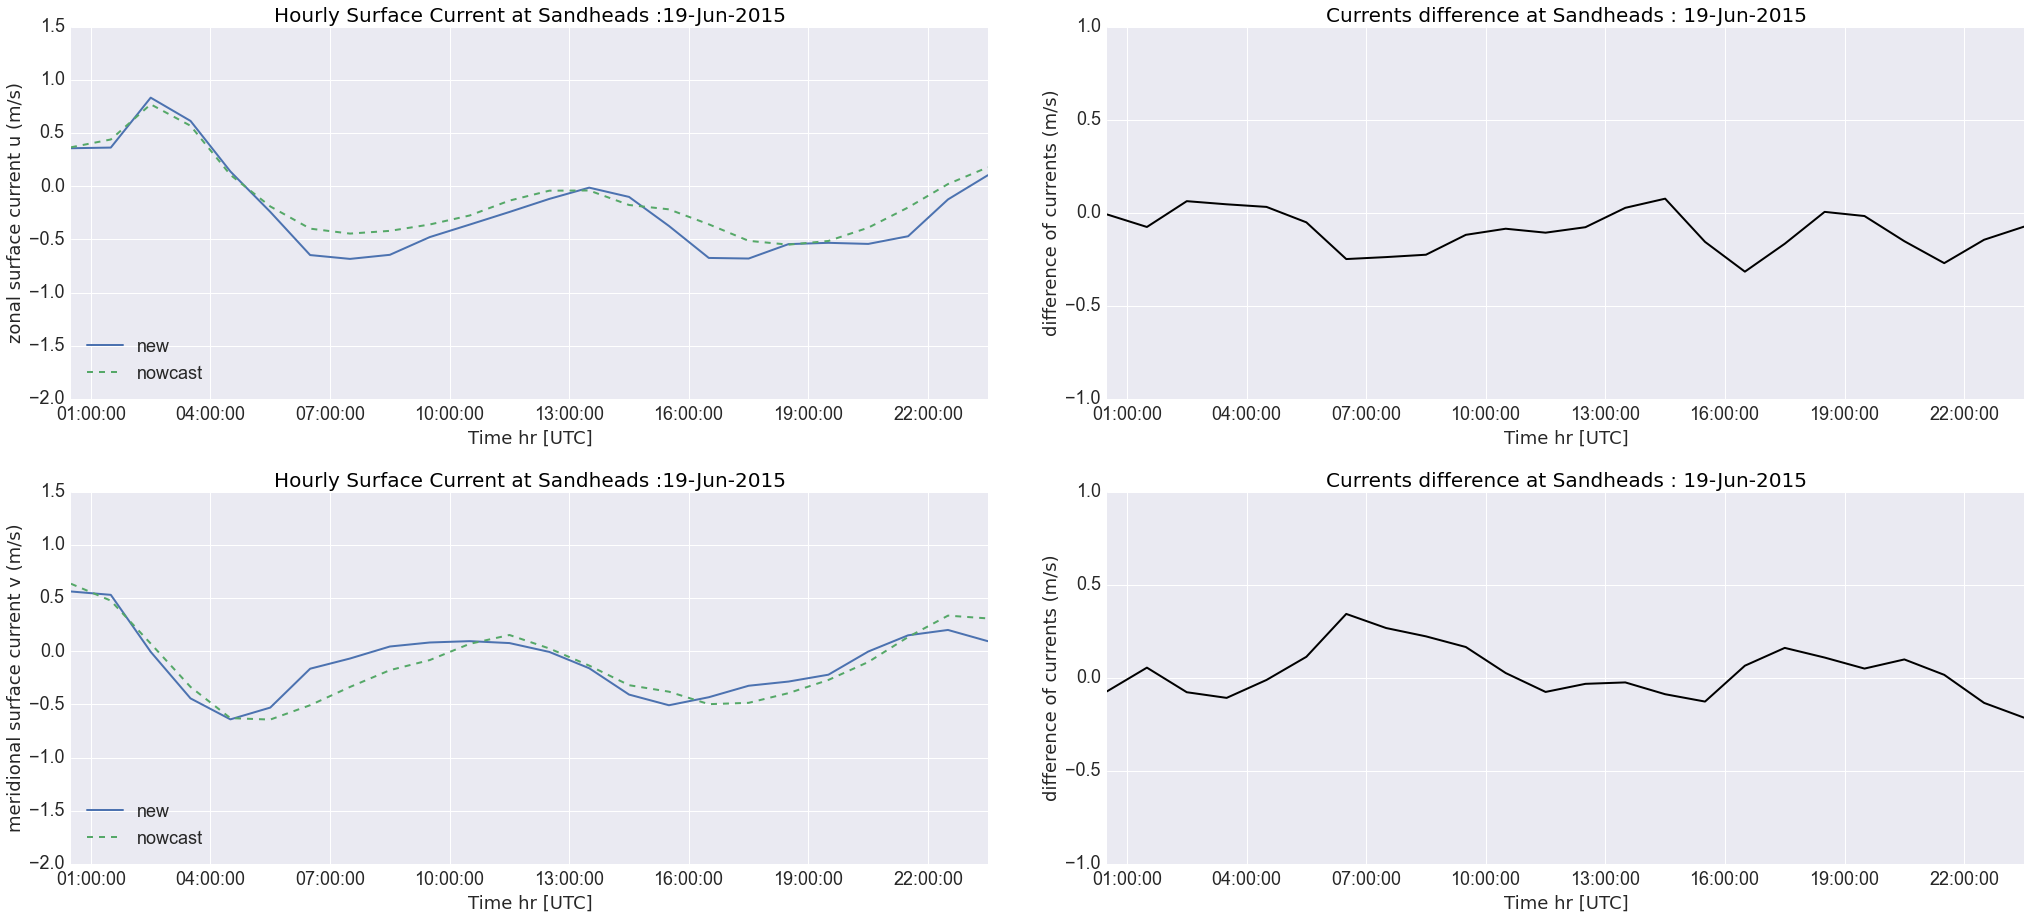

In [26]:
fig = compare_surfacecurrent_new(grid_T_19,0, u_19new, v_19new, u_19now, v_19now)

* For June 20

In [27]:
grid_T_20 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/20jun15/SalishSea_1h_20150620_20150620_grid_T.nc')
grid_U_new20 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150620_20150620_grid_U.nc')
grid_V_new20 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150620_20150620_grid_V.nc')
u_20new = grid_U_new20.variables['vozocrtx']
v_20new = grid_V_new20.variables['vomecrty']
grid_U_20 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/20jun15/SalishSea_1h_20150620_20150620_grid_U.nc')
grid_V_20 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/20jun15/SalishSea_1h_20150620_20150620_grid_V.nc')
u_20now = grid_U_20.variables['vozocrtx']
v_20now = grid_V_20.variables['vomecrty']

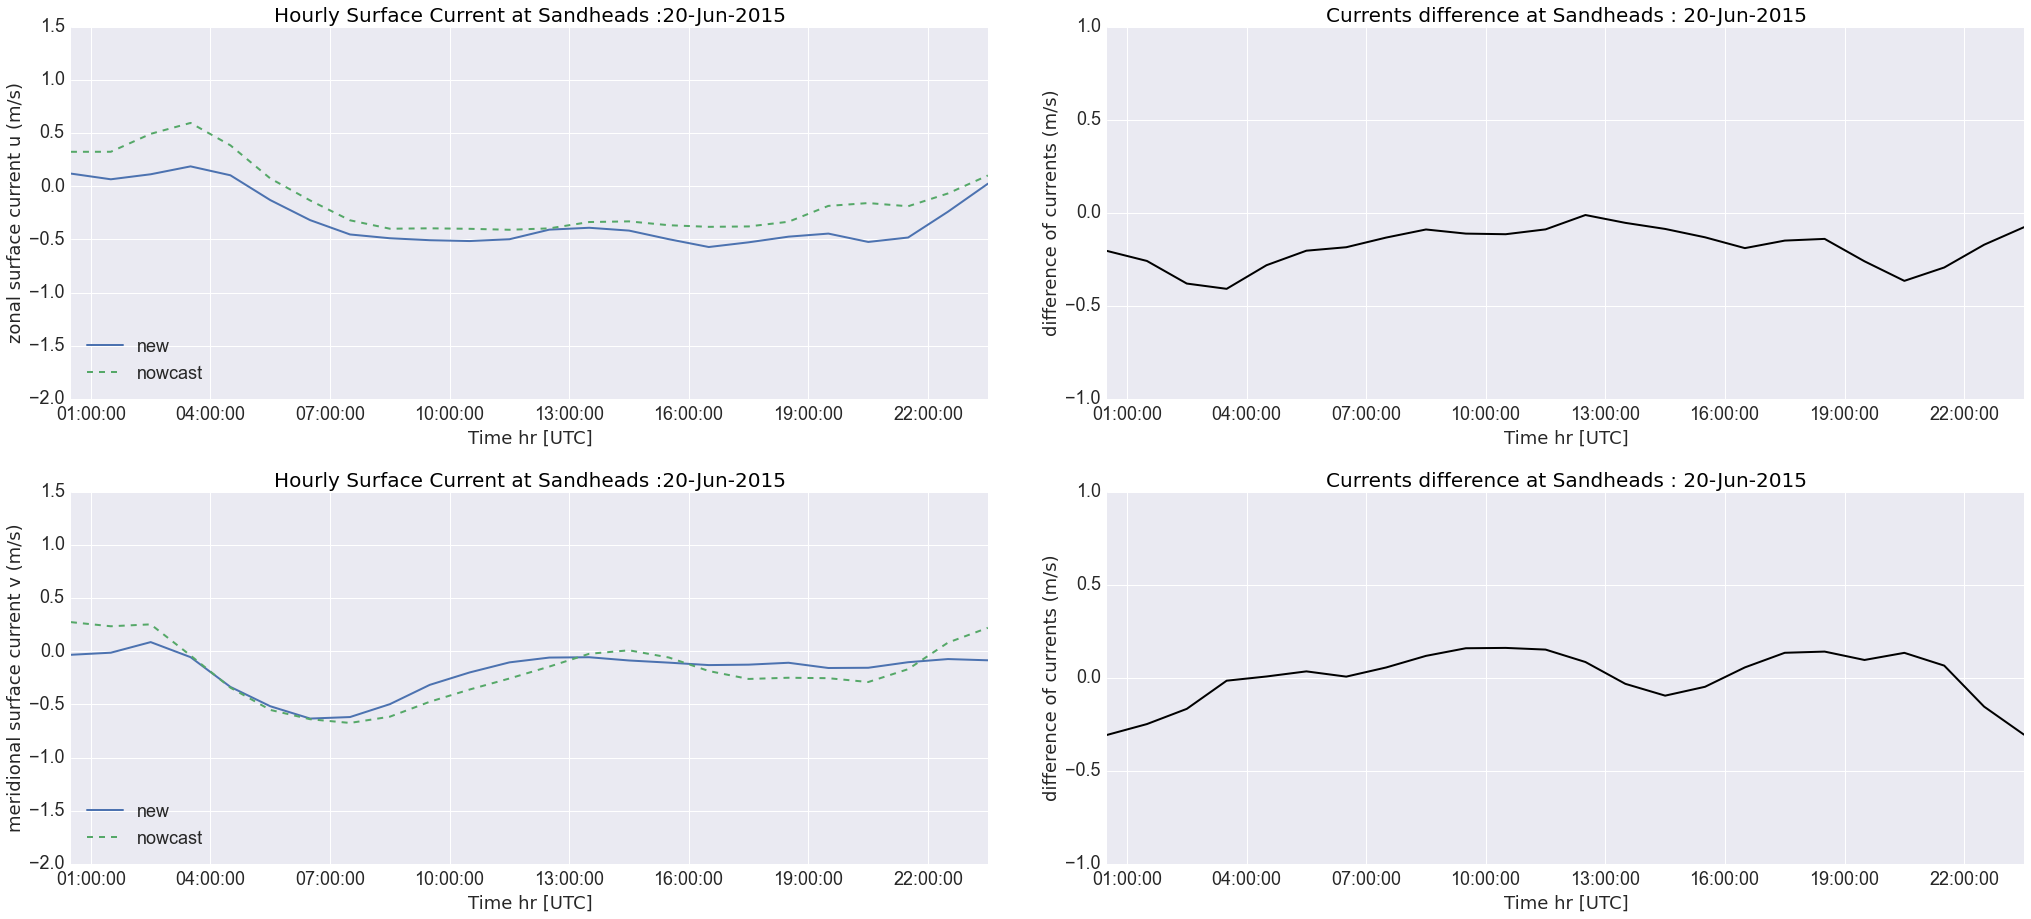

In [28]:
fig = compare_surfacecurrent_new(grid_T_20,0, u_20new, v_20new, u_20now, v_20now)

* For June 21

In [29]:
grid_T_21 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/21jun15/SalishSea_1h_20150621_20150621_grid_T.nc')
grid_U_new21 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150621_20150621_grid_U.nc')
grid_V_new21 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150621_20150621_grid_V.nc')
u_21new = grid_U_new21.variables['vozocrtx']
v_21new = grid_V_new21.variables['vomecrty']
grid_U_21 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/21jun15/SalishSea_1h_20150621_20150621_grid_U.nc')
grid_V_21 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/21jun15/SalishSea_1h_20150621_20150621_grid_V.nc')
u_21now = grid_U_21.variables['vozocrtx']
v_21now = grid_V_21.variables['vomecrty']

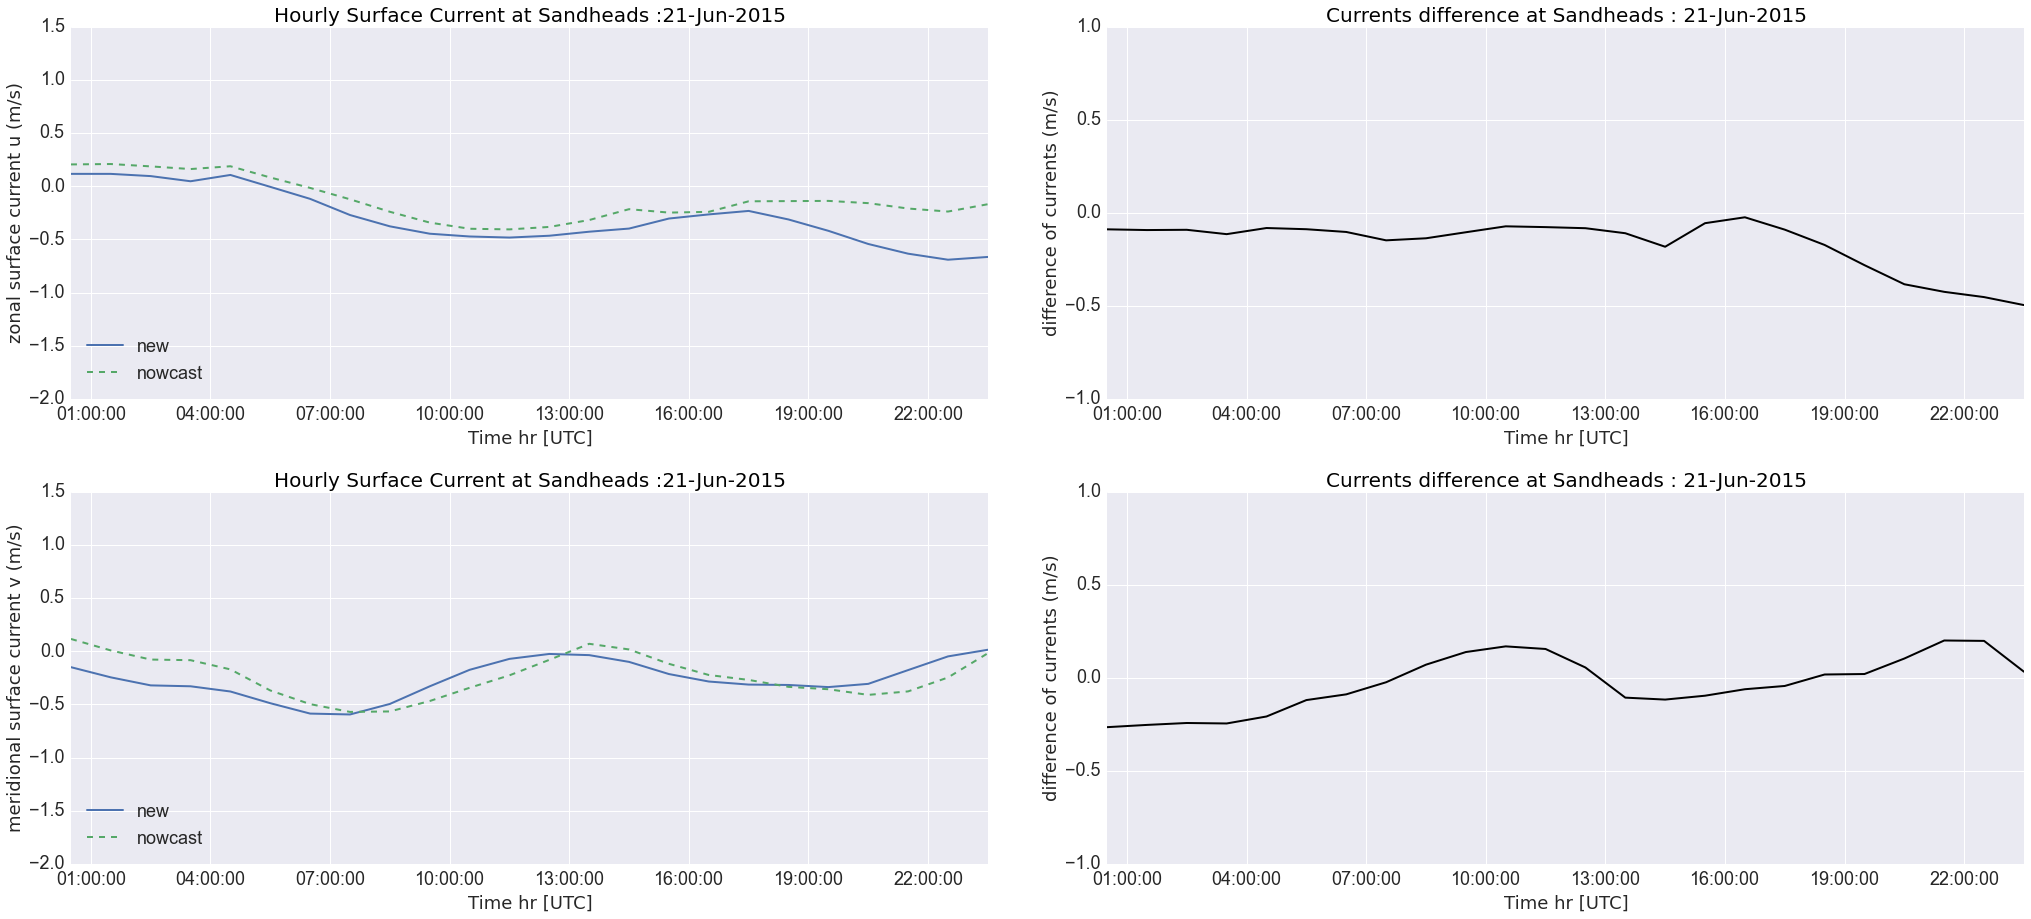

In [30]:
fig = compare_surfacecurrent_new(grid_T_21,0, u_21new, v_21new, u_21now, v_21now)

* For June22

In [31]:
grid_T_22 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/22jun15/SalishSea_1h_20150622_20150622_grid_T.nc')
grid_U_new22 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150622_20150622_grid_U.nc')
grid_V_new22 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150622_20150622_grid_V.nc')
u_22new = grid_U_new22.variables['vozocrtx']
v_22new = grid_V_new22.variables['vomecrty']
grid_U_22 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/22jun15/SalishSea_1h_20150622_20150622_grid_U.nc')
grid_V_22 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/22jun15/SalishSea_1h_20150622_20150622_grid_V.nc')
u_22now = grid_U_22.variables['vozocrtx']
v_22now = grid_V_22.variables['vomecrty']

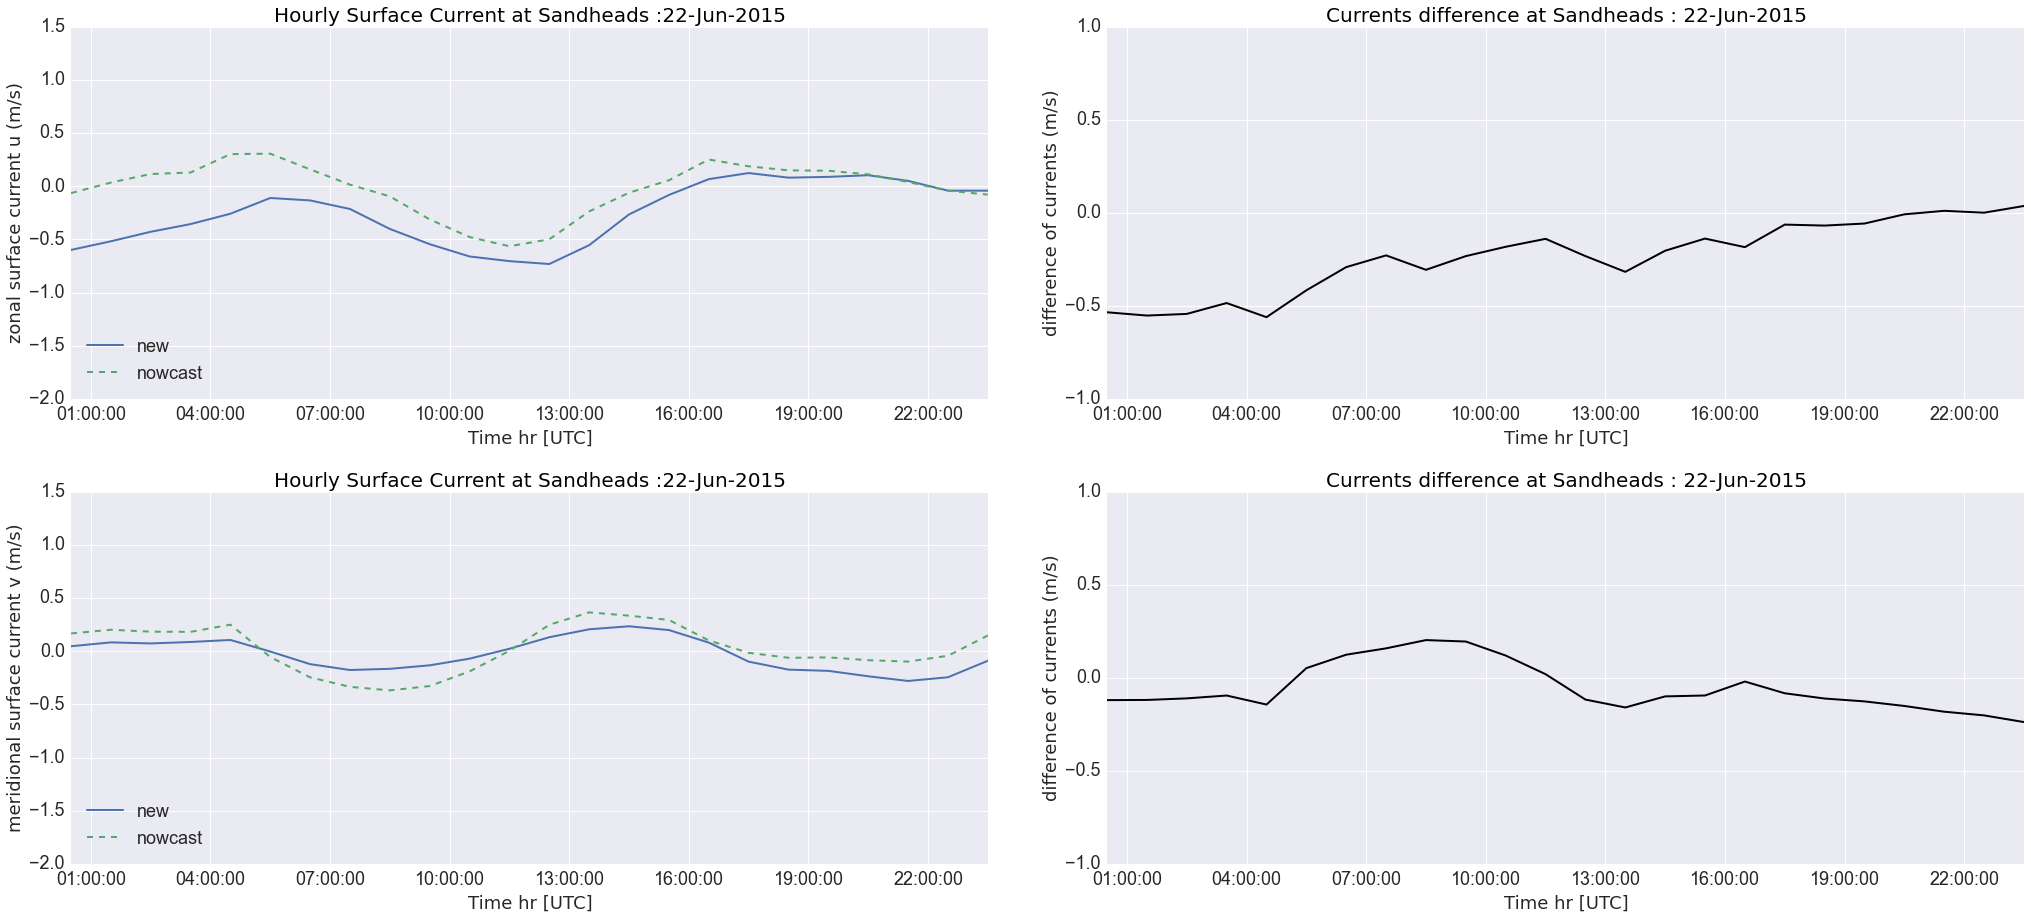

In [32]:
fig = compare_surfacecurrent_new(grid_T_22,0, u_22new, v_22new, u_22now, v_22now)

* For June 23

In [33]:
grid_T_23 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/23jun15/SalishSea_1h_20150623_20150623_grid_T.nc')
grid_U_new23 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150623_20150623_grid_U.nc')
grid_V_new23 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150623_20150623_grid_V.nc')
u_23new = grid_U_new23.variables['vozocrtx']
v_23new = grid_V_new23.variables['vomecrty']
grid_U_23 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/23jun15/SalishSea_1h_20150623_20150623_grid_U.nc')
grid_V_23 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/23jun15/SalishSea_1h_20150623_20150623_grid_V.nc')
u_23now = grid_U_23.variables['vozocrtx']
v_23now = grid_V_23.variables['vomecrty']

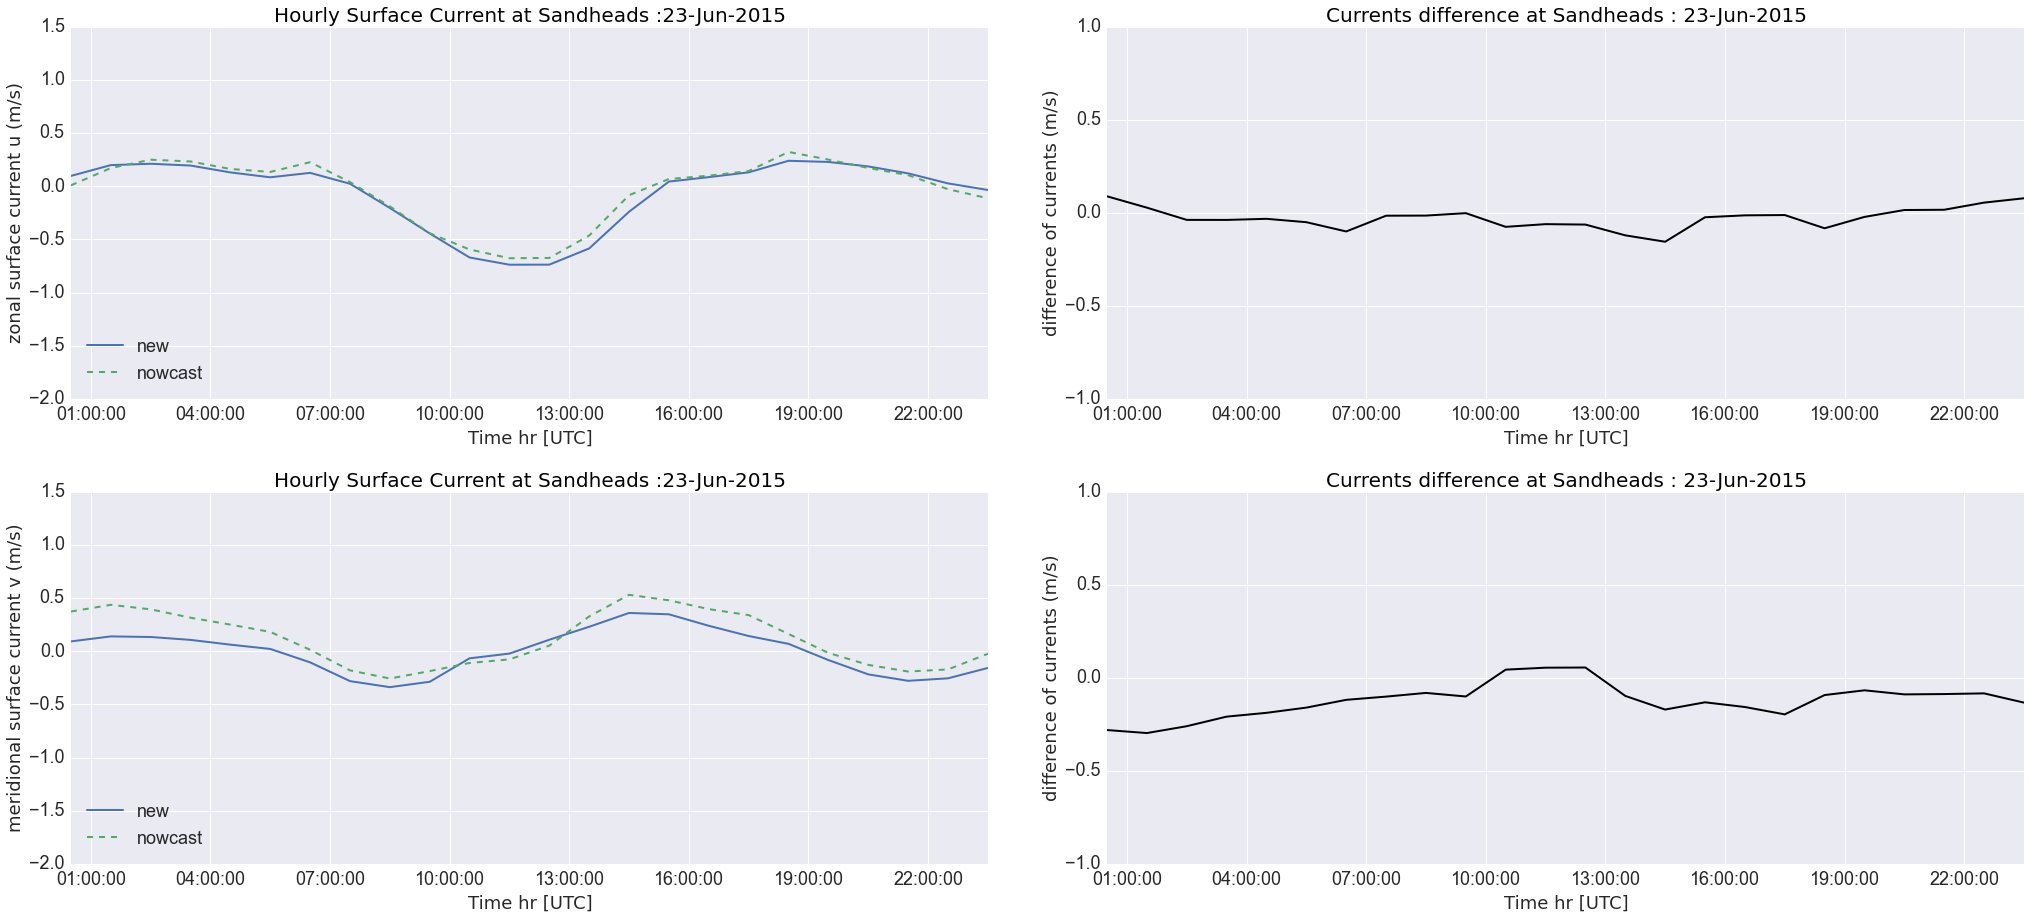

In [34]:
fig = compare_surfacecurrent_new(grid_T_23,0, u_23new, v_23new, u_23now, v_23now)

* For June 24

In [35]:
grid_T_24 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/24jun15/SalishSea_1h_20150624_20150624_grid_T.nc')
grid_U_new24 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150624_20150624_grid_U.nc')
grid_V_new24 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150624_20150624_grid_V.nc')
u_24new = grid_U_new24.variables['vozocrtx']
v_24new = grid_V_new24.variables['vomecrty']
grid_U_24 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/24jun15/SalishSea_1h_20150624_20150624_grid_U.nc')
grid_V_24 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/24jun15/SalishSea_1h_20150624_20150624_grid_V.nc')
u_24now = grid_U_24.variables['vozocrtx']
v_24now = grid_V_24.variables['vomecrty']

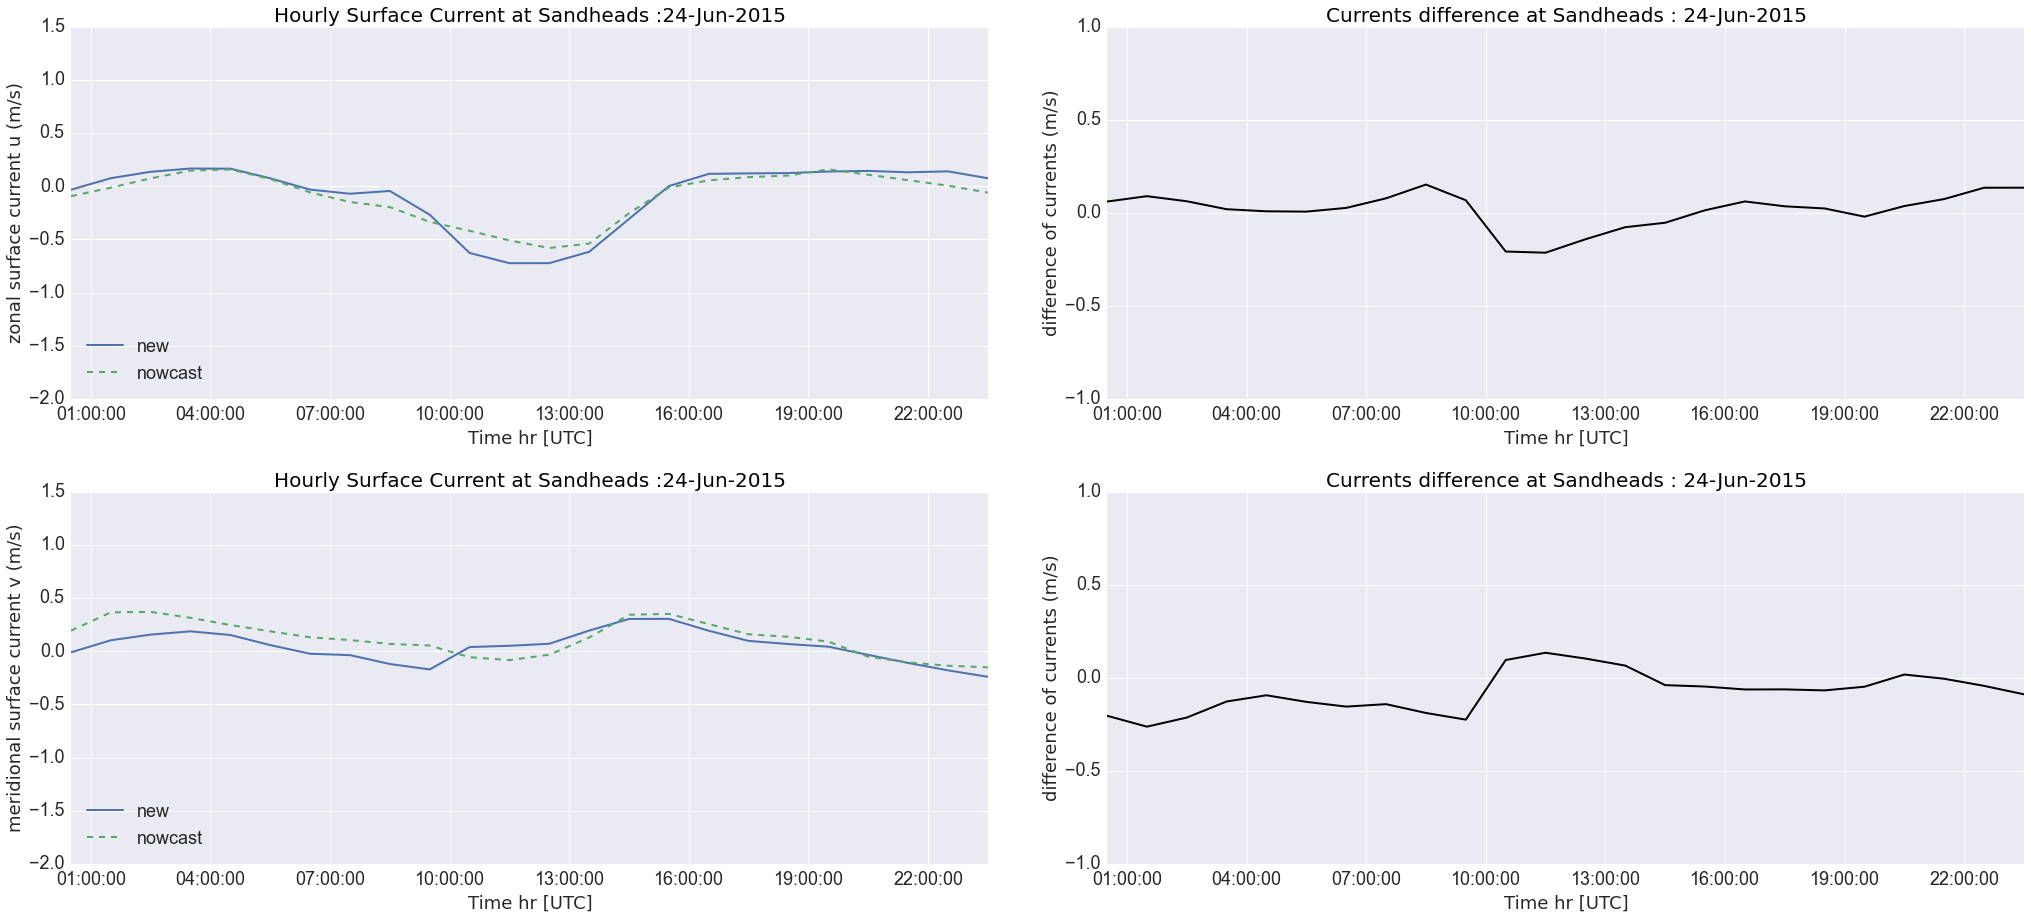

In [36]:
fig = compare_surfacecurrent_new(grid_T_24,0, u_24new, v_24new, u_24now, v_24now)

* For June 25

In [37]:
grid_T_25 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/25jun15/SalishSea_1h_20150625_20150625_grid_T.nc')
grid_U_new25 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150625_20150625_grid_U.nc')
grid_V_new25 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150625_20150625_grid_V.nc')
u_25new = grid_U_new25.variables['vozocrtx']
v_25new = grid_V_new25.variables['vomecrty']
grid_U_25 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/25jun15/SalishSea_1h_20150625_20150625_grid_U.nc')
grid_V_25 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/25jun15/SalishSea_1h_20150625_20150625_grid_V.nc')
u_25now = grid_U_25.variables['vozocrtx']
v_25now = grid_V_25.variables['vomecrty']

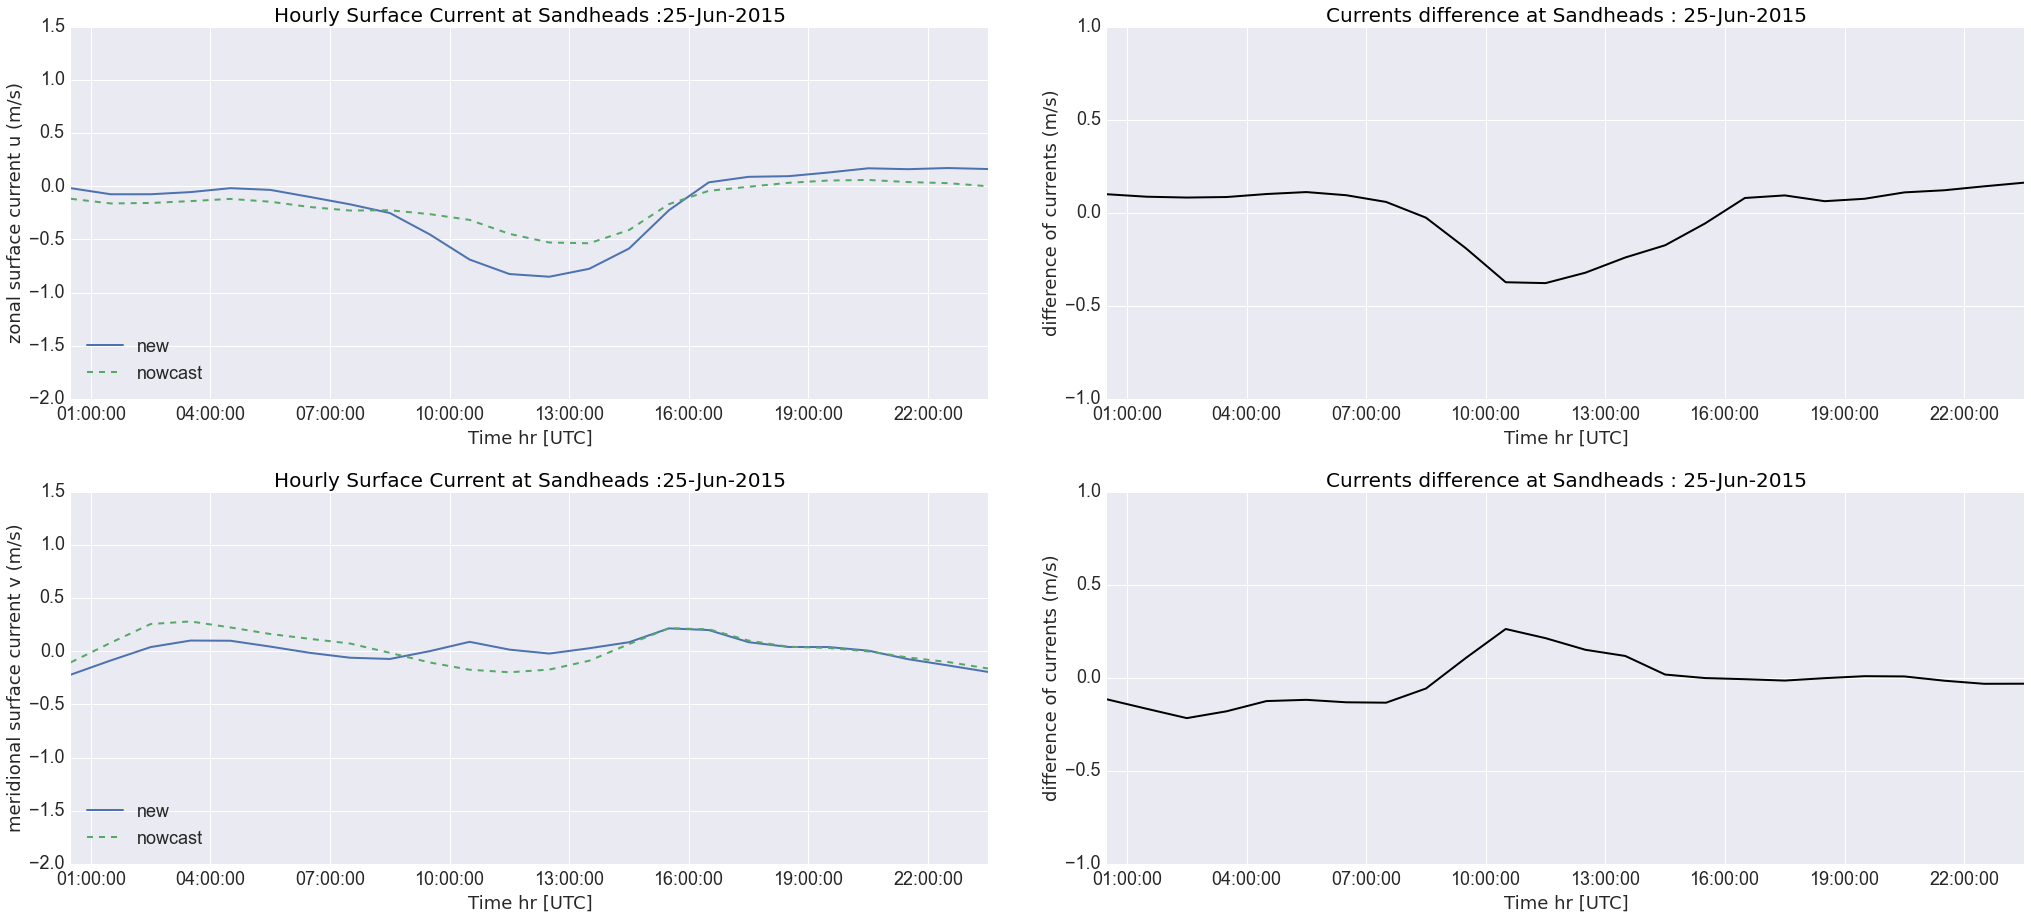

In [38]:
fig = compare_surfacecurrent_new(grid_T_25,0, u_25new, v_25new, u_25now, v_25now)

* For June 26

In [39]:
grid_T_26 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/26jun15/SalishSea_1h_20150626_20150626_grid_T.nc')
grid_U_new26 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150626_20150626_grid_U.nc')
grid_V_new26 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150626_20150626_grid_V.nc')
u_26new = grid_U_new26.variables['vozocrtx']
v_26new = grid_V_new26.variables['vomecrty']
grid_U_26 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/26jun15/SalishSea_1h_20150626_20150626_grid_U.nc')
grid_V_26 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/26jun15/SalishSea_1h_20150626_20150626_grid_V.nc')
u_26now = grid_U_26.variables['vozocrtx']
v_26now = grid_V_26.variables['vomecrty']

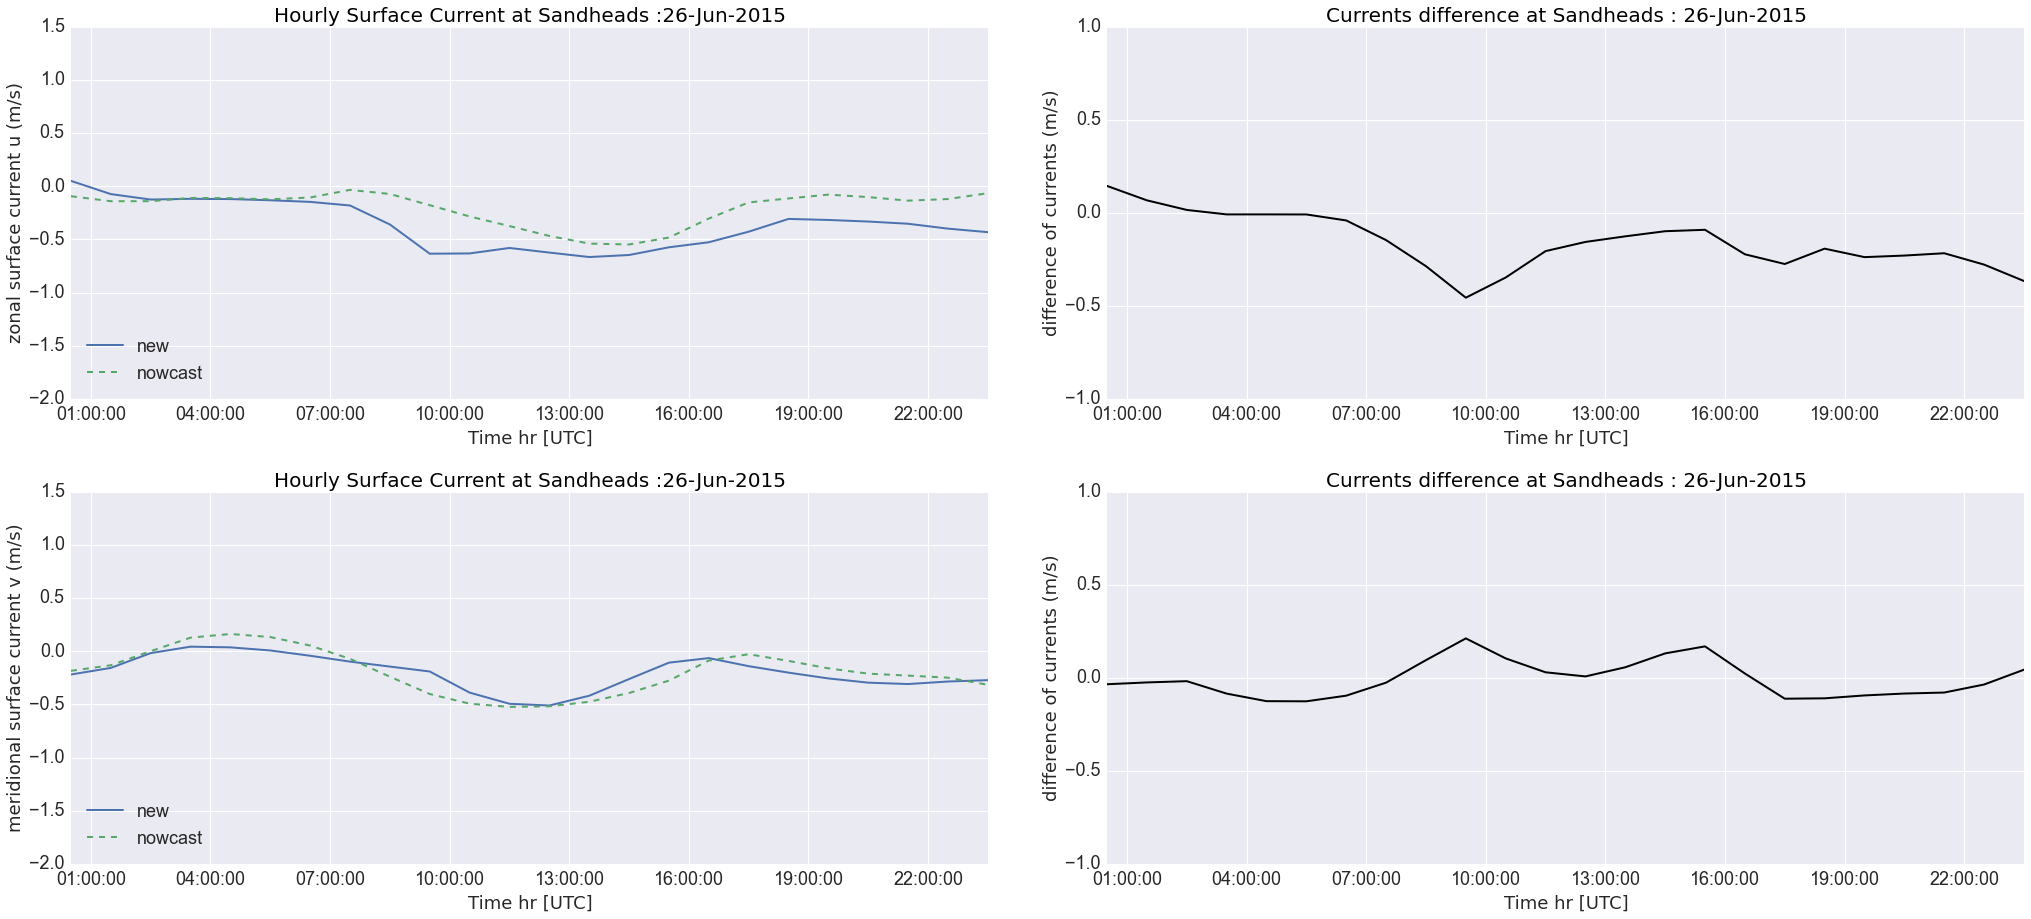

In [40]:
fig = compare_surfacecurrent_new(grid_T_26,0, u_26new, v_26new, u_26now, v_26now)

* For June 27

In [41]:
grid_T_27 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/27jun15/SalishSea_1h_20150627_20150627_grid_T.nc')
grid_U_new27 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150627_20150627_grid_U.nc')
grid_V_new27 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150627_20150627_grid_V.nc')
u_27new = grid_U_new27.variables['vozocrtx']
v_27new = grid_V_new27.variables['vomecrty']
grid_U_27 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/27jun15/SalishSea_1h_20150627_20150627_grid_U.nc')
grid_V_27 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/27jun15/SalishSea_1h_20150627_20150627_grid_V.nc')
u_27now = grid_U_27.variables['vozocrtx']
v_27now = grid_V_27.variables['vomecrty']

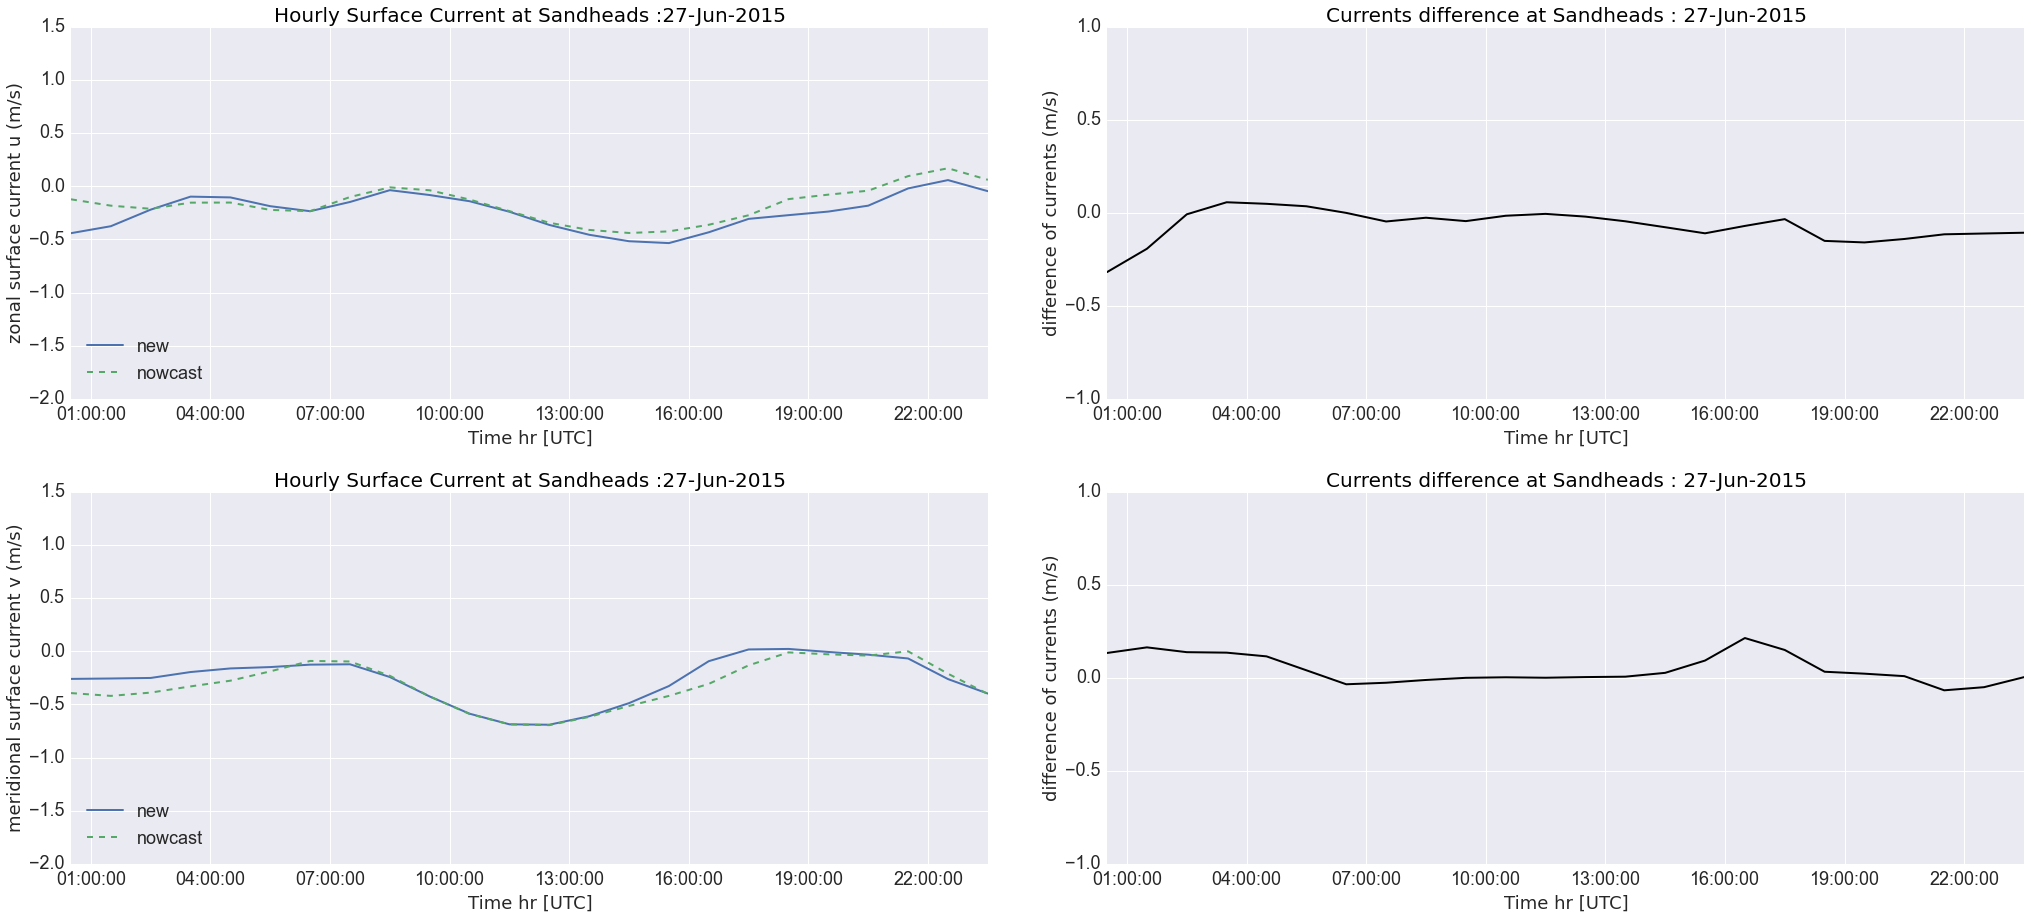

In [42]:
fig = compare_surfacecurrent_new(grid_T_27,0, u_27new, v_27new, u_27now, v_27now)

* For June 28

In [43]:
grid_T_28 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/28jun15/SalishSea_1h_20150628_20150628_grid_T.nc')
grid_U_new28 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150628_20150628_grid_U.nc')
grid_V_new28 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150628_20150628_grid_V.nc')
u_28new = grid_U_new26.variables['vozocrtx']
v_28new = grid_V_new26.variables['vomecrty']
grid_U_28 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/28jun15/SalishSea_1h_20150628_20150628_grid_U.nc')
grid_V_28 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/28jun15/SalishSea_1h_20150628_20150628_grid_V.nc')
u_28now = grid_U_28.variables['vozocrtx']
v_28now = grid_V_28.variables['vomecrty']

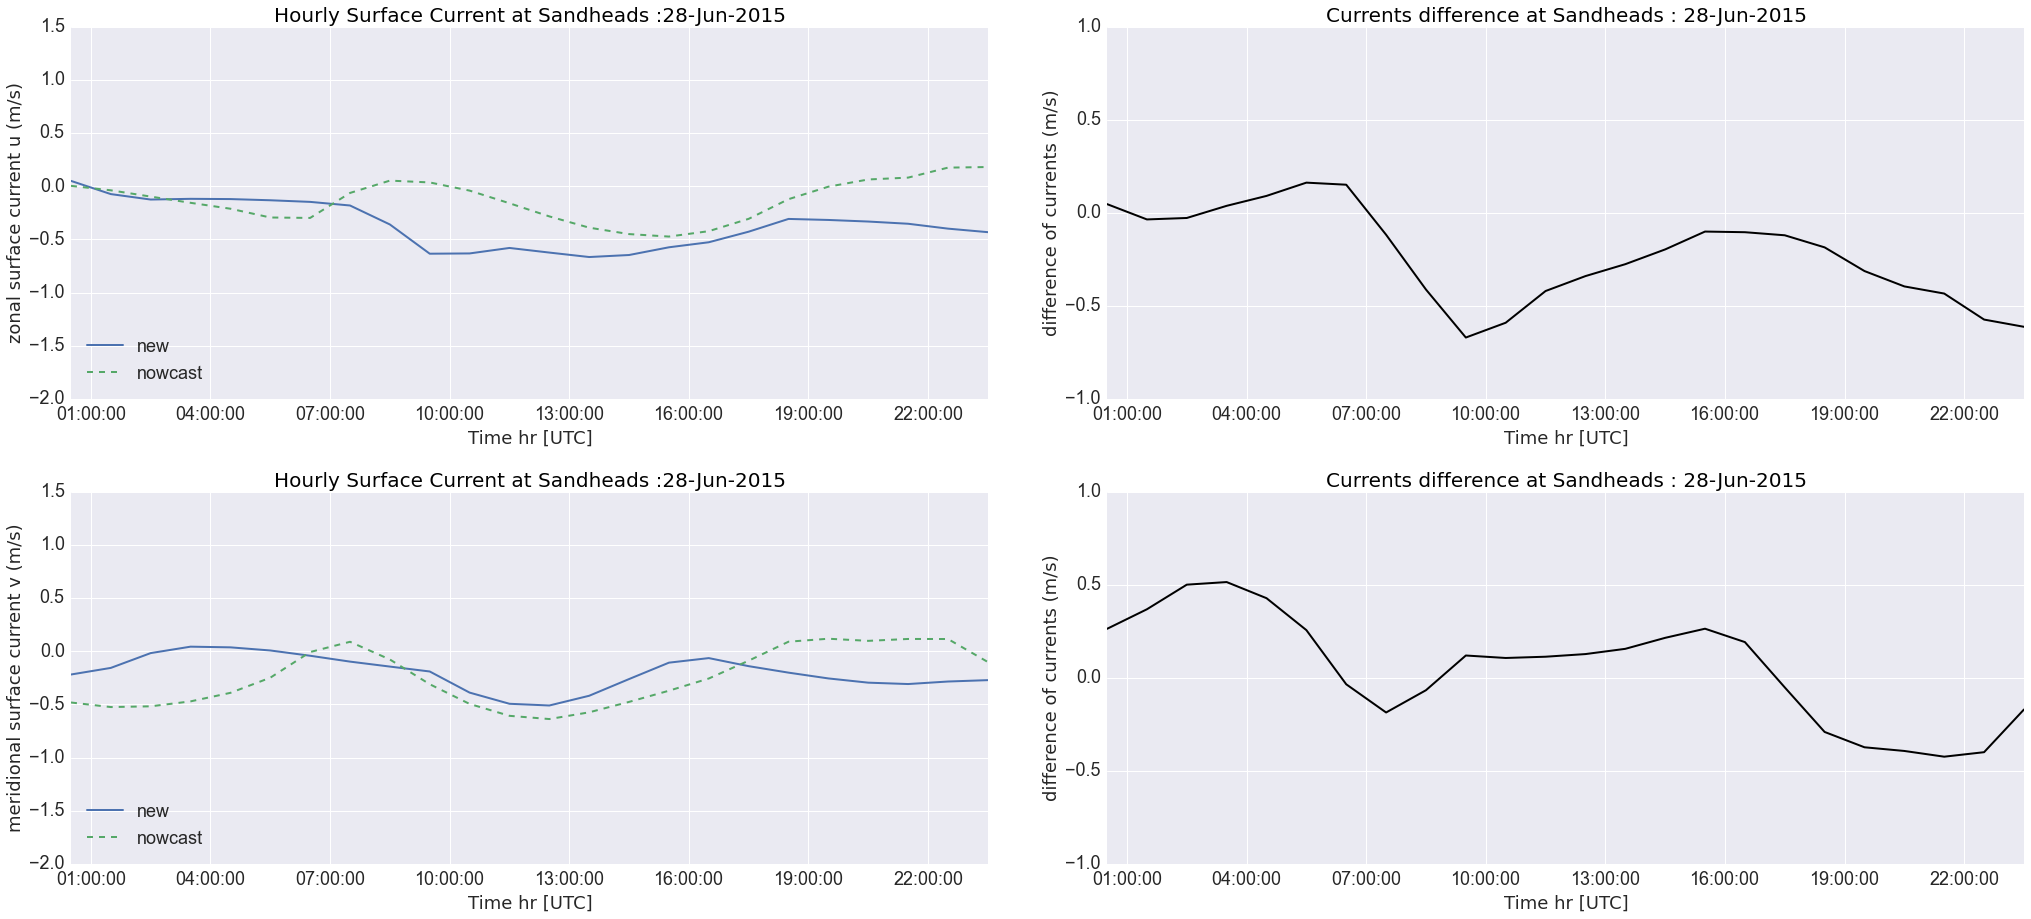

In [44]:
fig = compare_surfacecurrent_new(grid_T_28,0, u_28new, v_28new, u_28now, v_28now)

* For June 29

In [45]:
grid_T_29 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/29jun15/SalishSea_1h_20150629_20150629_grid_T.nc')
grid_U_new29 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150629_20150629_grid_U.nc')
grid_V_new29 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150629_20150629_grid_V.nc')
u_29new = grid_U_new26.variables['vozocrtx']
v_29new = grid_V_new26.variables['vomecrty']
grid_U_29 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/29jun15/SalishSea_1h_20150629_20150629_grid_U.nc')
grid_V_29 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/29jun15/SalishSea_1h_20150629_20150629_grid_V.nc')
u_29now = grid_U_29.variables['vozocrtx']
v_29now = grid_V_29.variables['vomecrty']

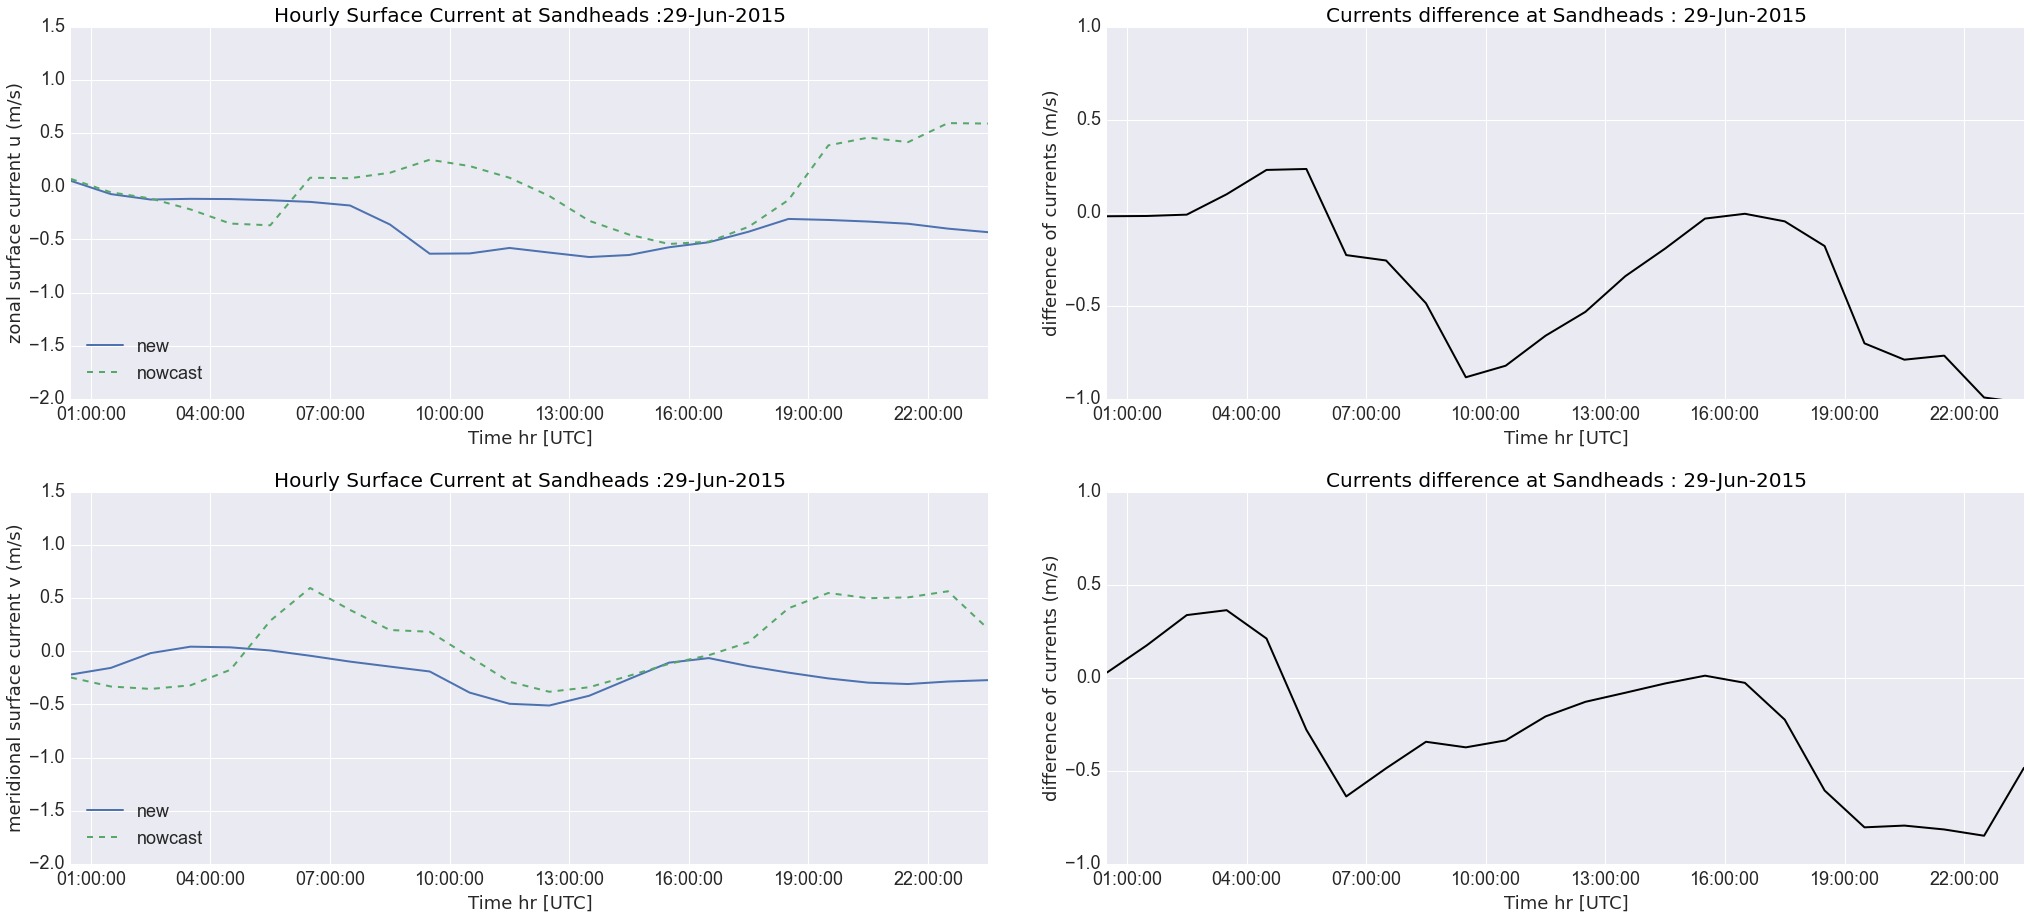

In [46]:
fig = compare_surfacecurrent_new(grid_T_29,0, u_29new, v_29new, u_29now, v_29now)

# Currents comparisons between Doug's nowcasts and my nowcasts from cold start

* For June 15

In [10]:
grid_U_mynow15 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/24hrs_nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_U.nc')
grid_V_mynow15 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/24hrs_nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_V.nc')
u_15mynow = grid_U_mynow15.variables['vozocrtx']
v_15mynow = grid_V_mynow15.variables['vomecrty']

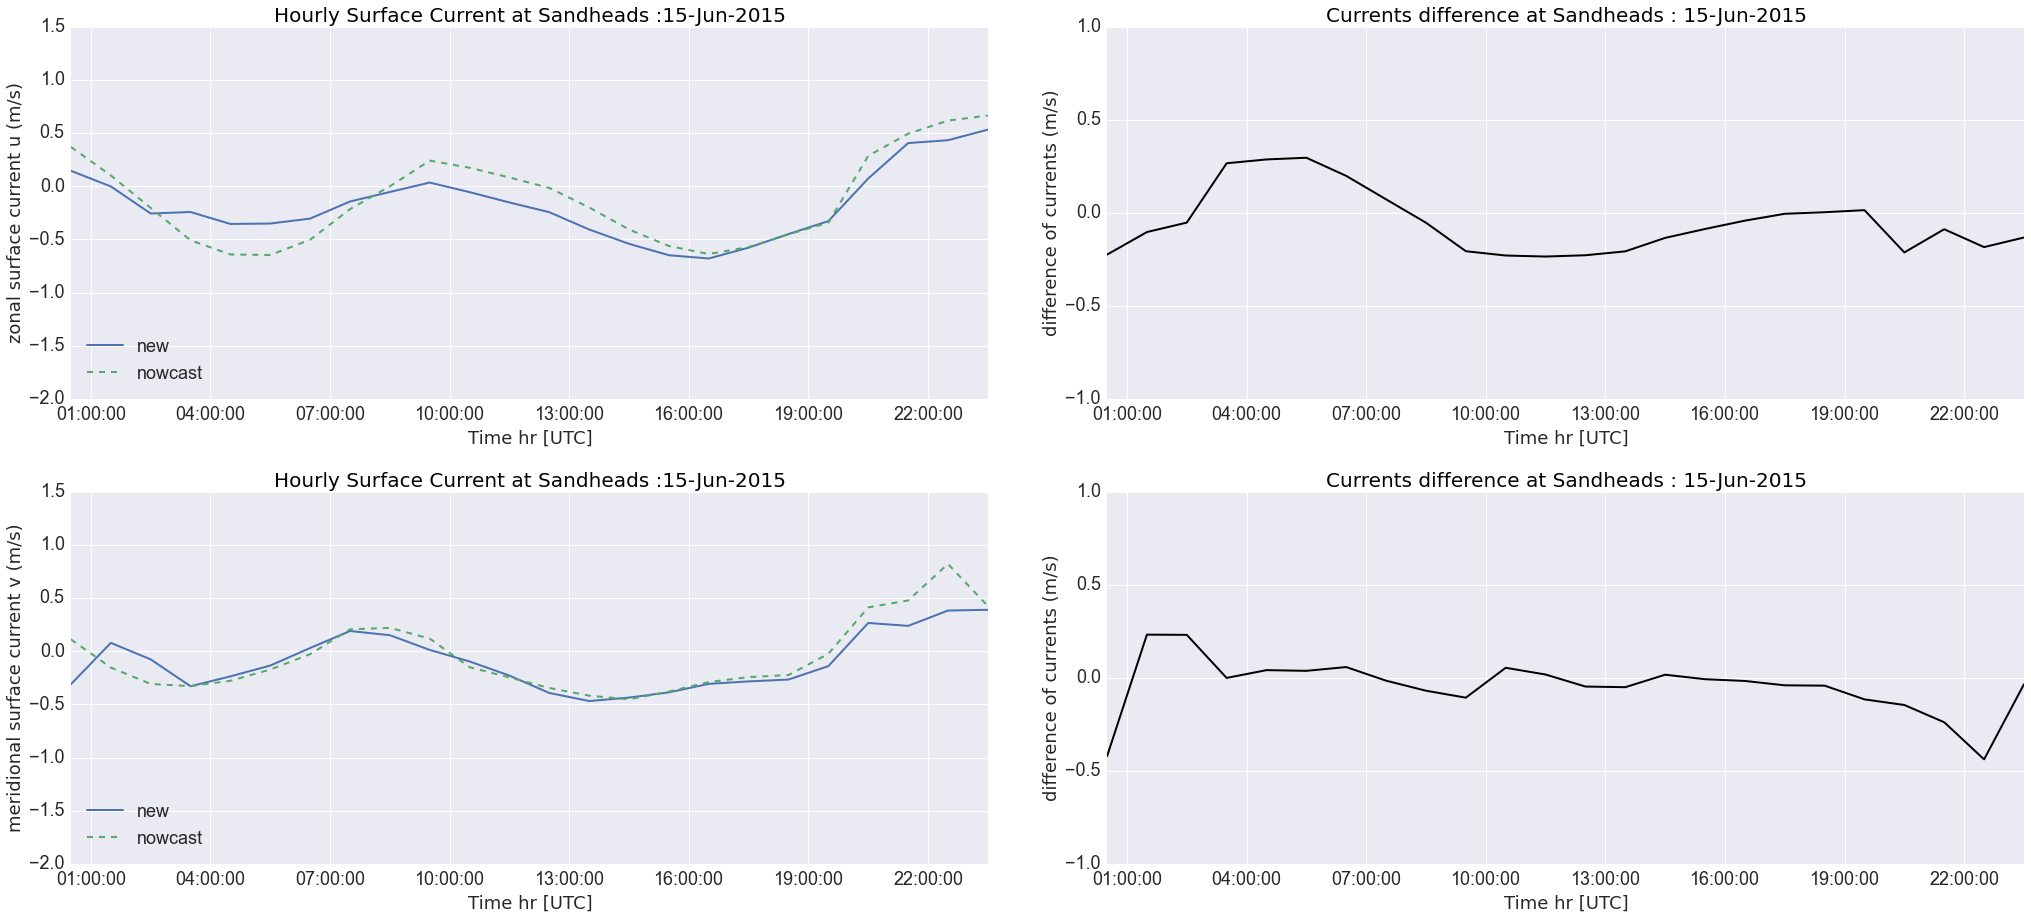

In [11]:
fig = compare_surfacecurrent_new(grid_T_15, 0, u_15mynow, v_15mynow, u_15now, v_15now)

* For June 16

In [49]:
grid_U_mynow16 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150616_20150616_grid_U.nc')
grid_V_mynow16 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150616_20150616_grid_V.nc')
u_16mynow = grid_U_mynow16.variables['vozocrtx']
v_16mynow = grid_V_mynow16.variables['vomecrty']

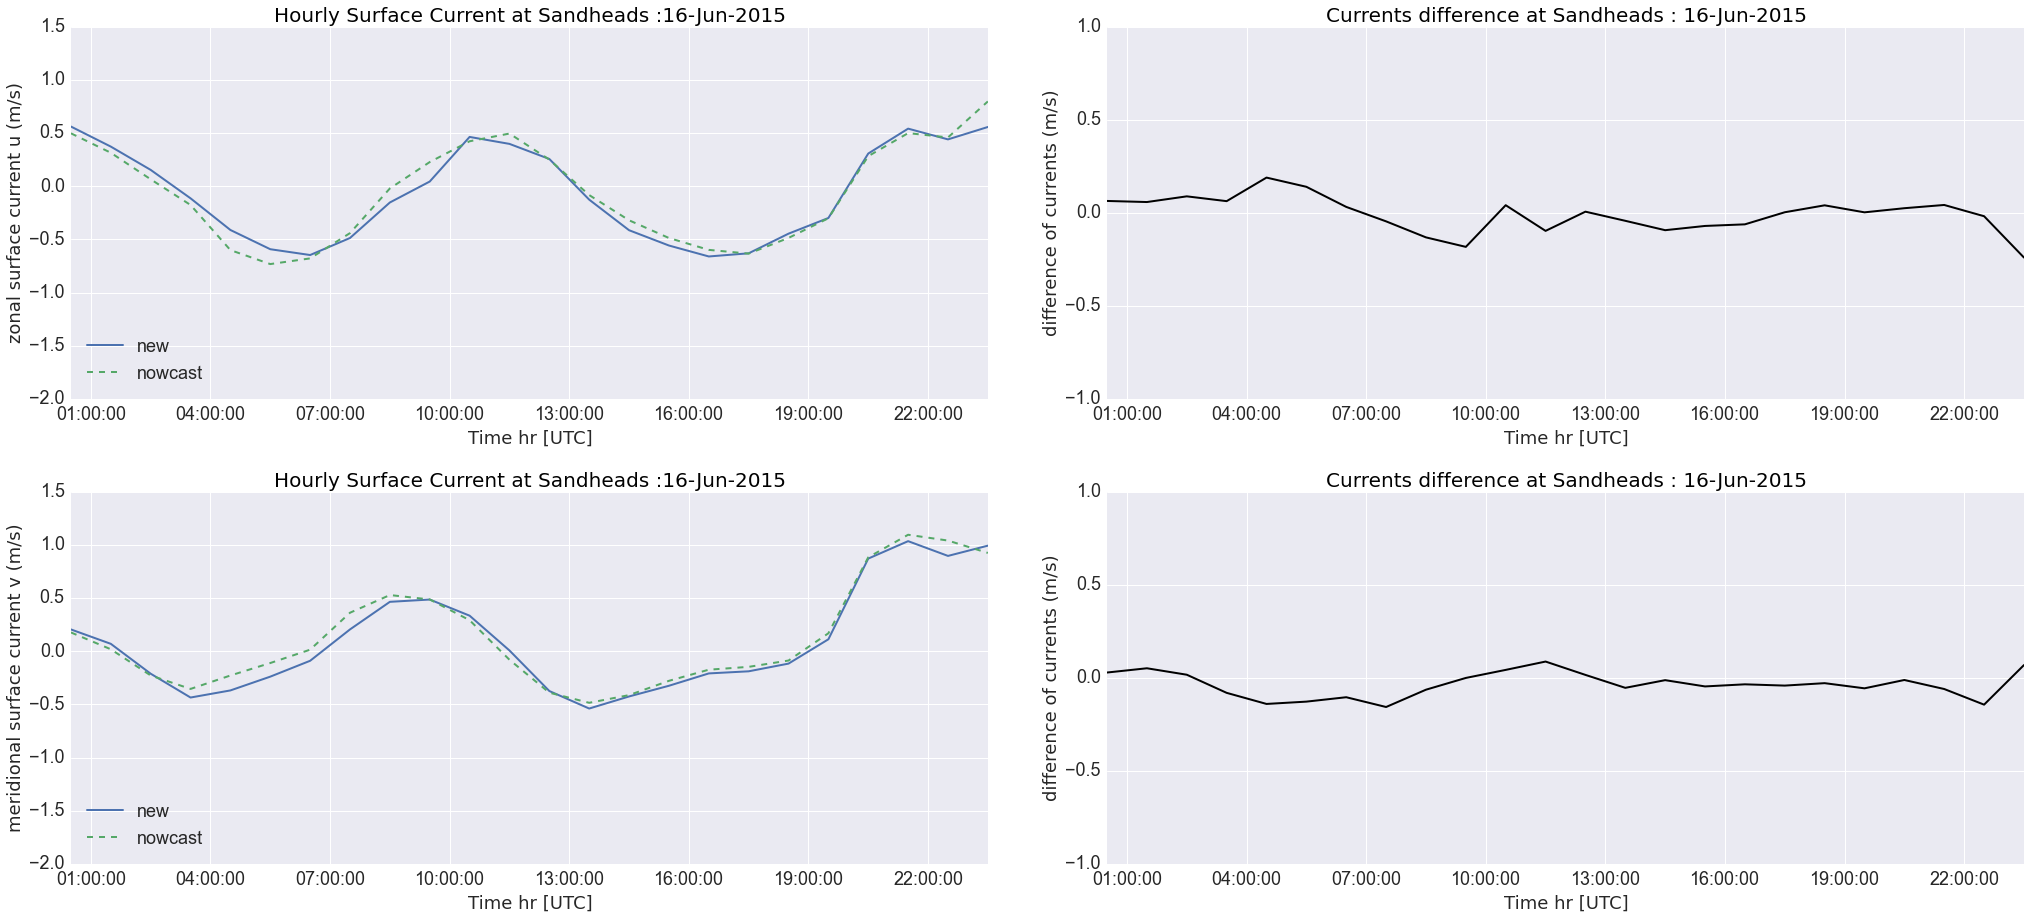

In [50]:
fig = compare_surfacecurrent_new(grid_T_16, 0, u_16mynow, v_16mynow, u_16now, v_16now)

* For June 17

In [51]:
grid_U_mynow17 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150617_20150617_grid_U.nc')
grid_V_mynow17 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150617_20150617_grid_V.nc')
u_17mynow = grid_U_mynow17.variables['vozocrtx']
v_17mynow = grid_V_mynow17.variables['vomecrty']

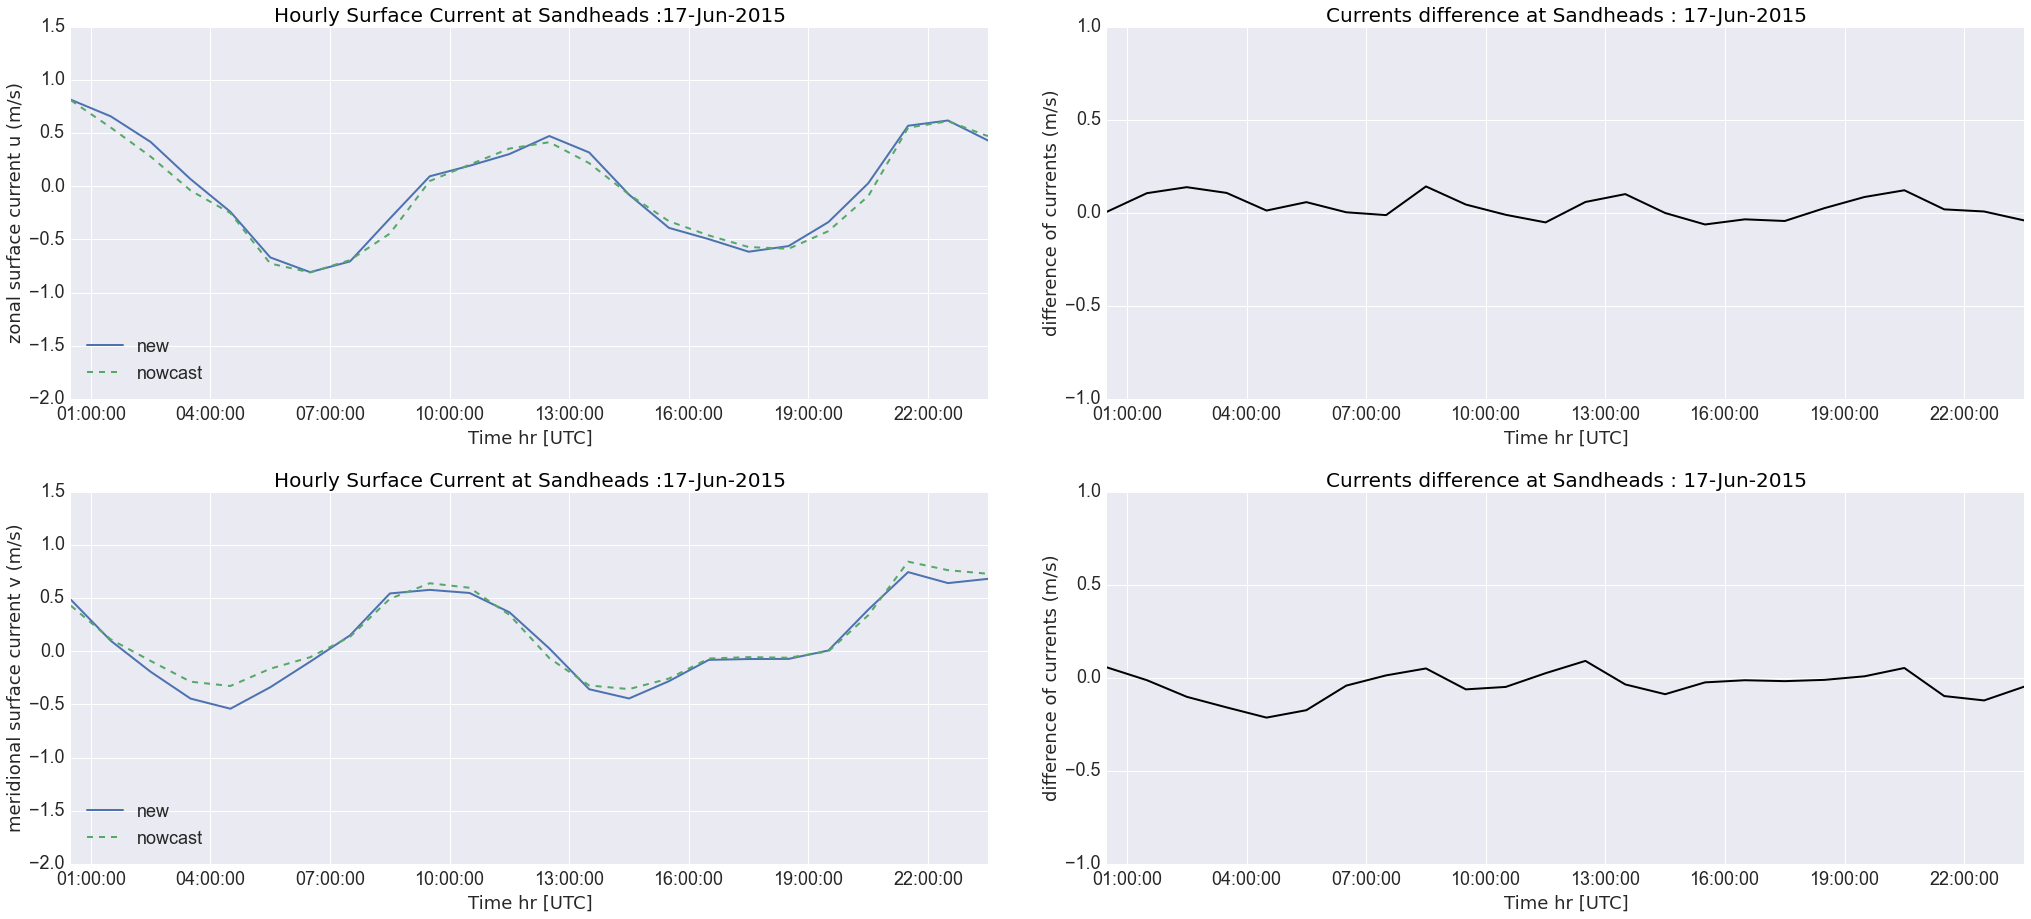

In [52]:
fig = compare_surfacecurrent_new(grid_T_17, 0, u_17mynow, v_17mynow, u_17now, v_17now)

* For June 18

In [53]:
grid_U_mynow18 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150618_20150618_grid_U.nc')
grid_V_mynow18 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150618_20150618_grid_V.nc')
u_18mynow = grid_U_mynow18.variables['vozocrtx']
v_18mynow = grid_V_mynow18.variables['vomecrty']

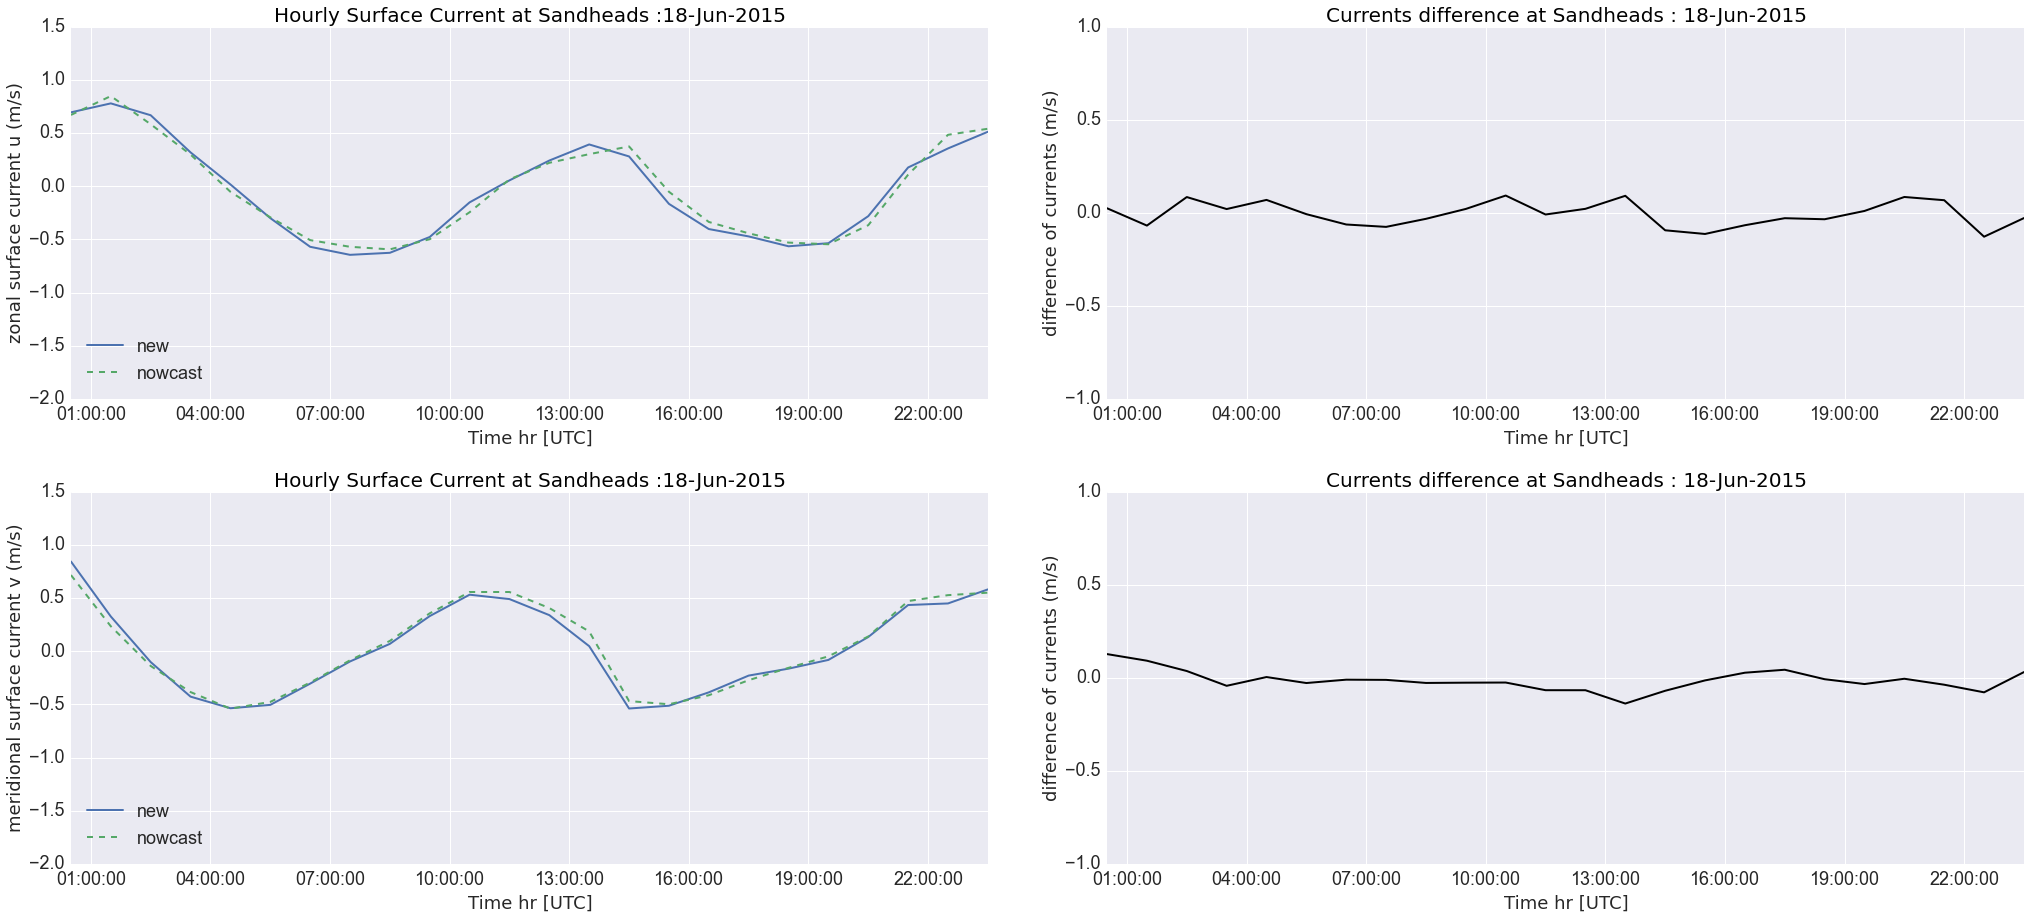

In [54]:
fig = compare_surfacecurrent_new(grid_T_18, 0, u_18mynow, v_18mynow, u_18now, v_18now)

* For June 19

In [55]:
grid_U_mynow19 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150619_20150619_grid_U.nc')
grid_V_mynow19 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150619_20150619_grid_V.nc')
u_19mynow = grid_U_mynow19.variables['vozocrtx']
v_19mynow = grid_V_mynow19.variables['vomecrty']

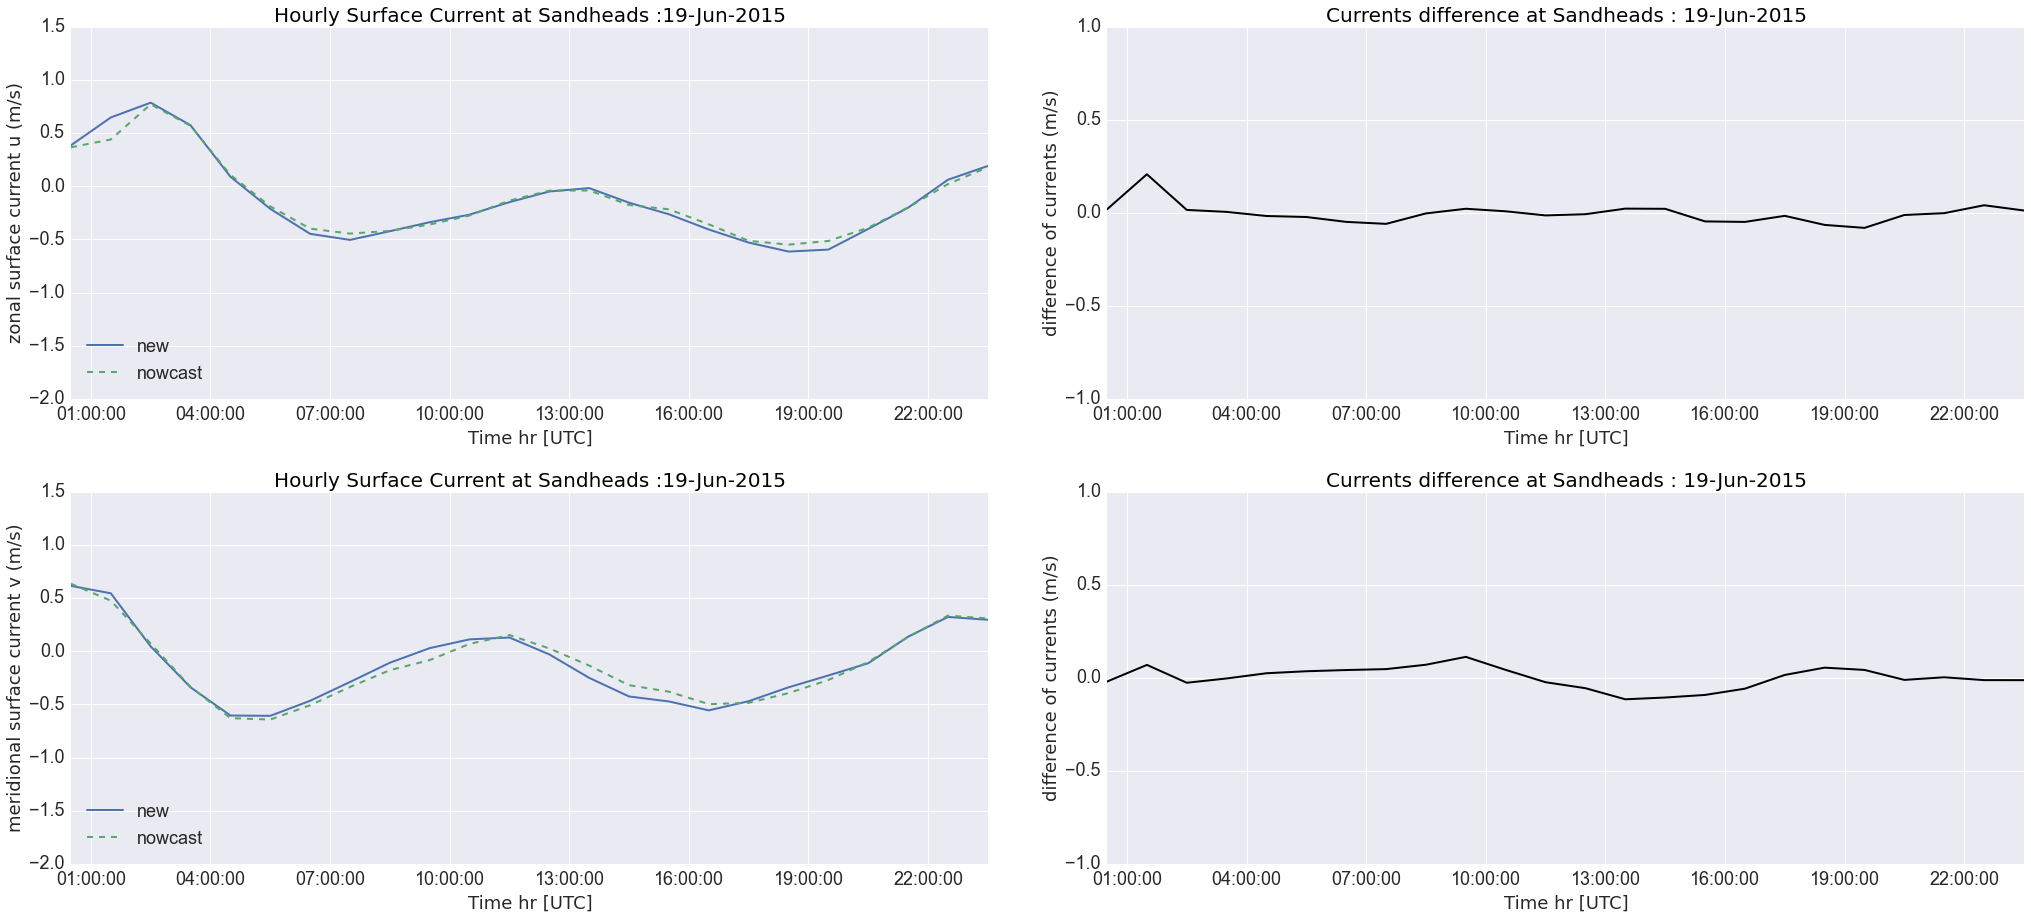

In [56]:
fig = compare_surfacecurrent_new(grid_T_19, 0, u_19mynow, v_19mynow, u_19now, v_19now)

* For June 20

In [57]:
grid_U_mynow20 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150620_20150620_grid_U.nc')
grid_V_mynow20 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150620_20150620_grid_V.nc')
u_20mynow = grid_U_mynow20.variables['vozocrtx']
v_20mynow = grid_V_mynow20.variables['vomecrty']

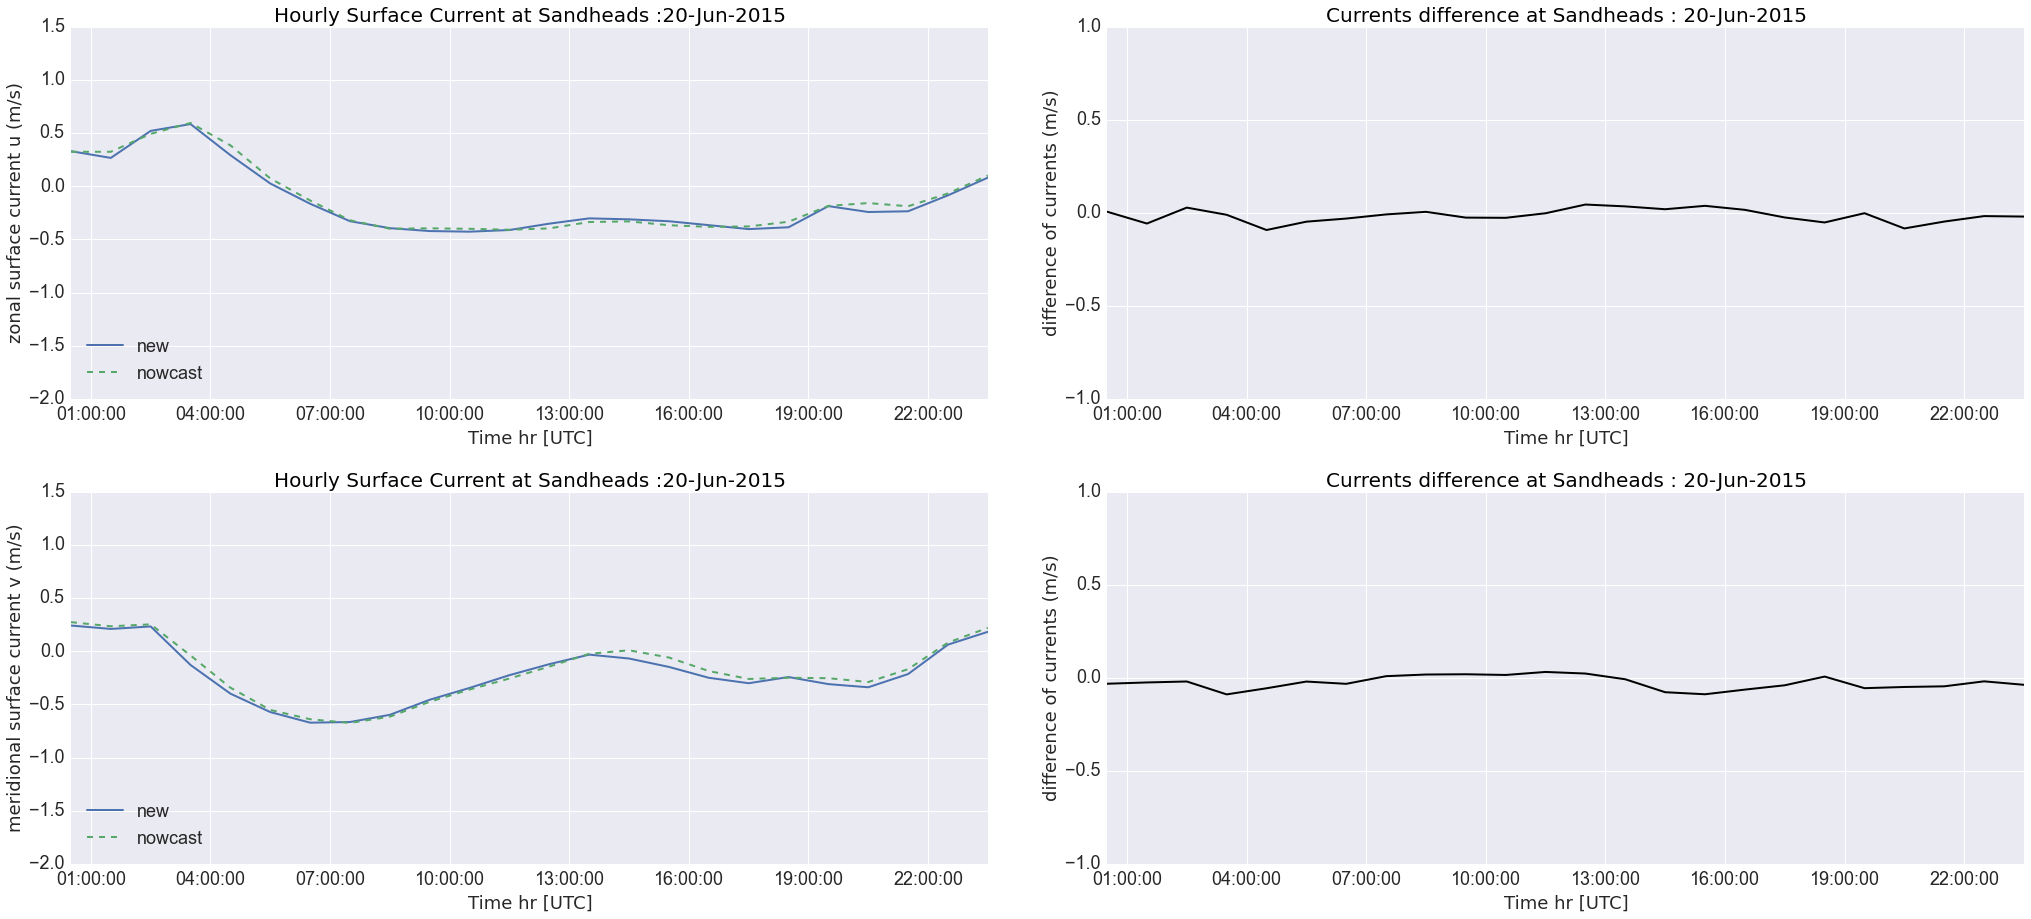

In [58]:
fig = compare_surfacecurrent_new(grid_T_20, 0, u_20mynow, v_20mynow, u_20now, v_20now)

* For June 21

In [59]:
grid_U_mynow21 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150621_20150621_grid_U.nc')
grid_V_mynow21 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150621_20150621_grid_V.nc')
u_21mynow = grid_U_mynow21.variables['vozocrtx']
v_21mynow = grid_V_mynow21.variables['vomecrty']

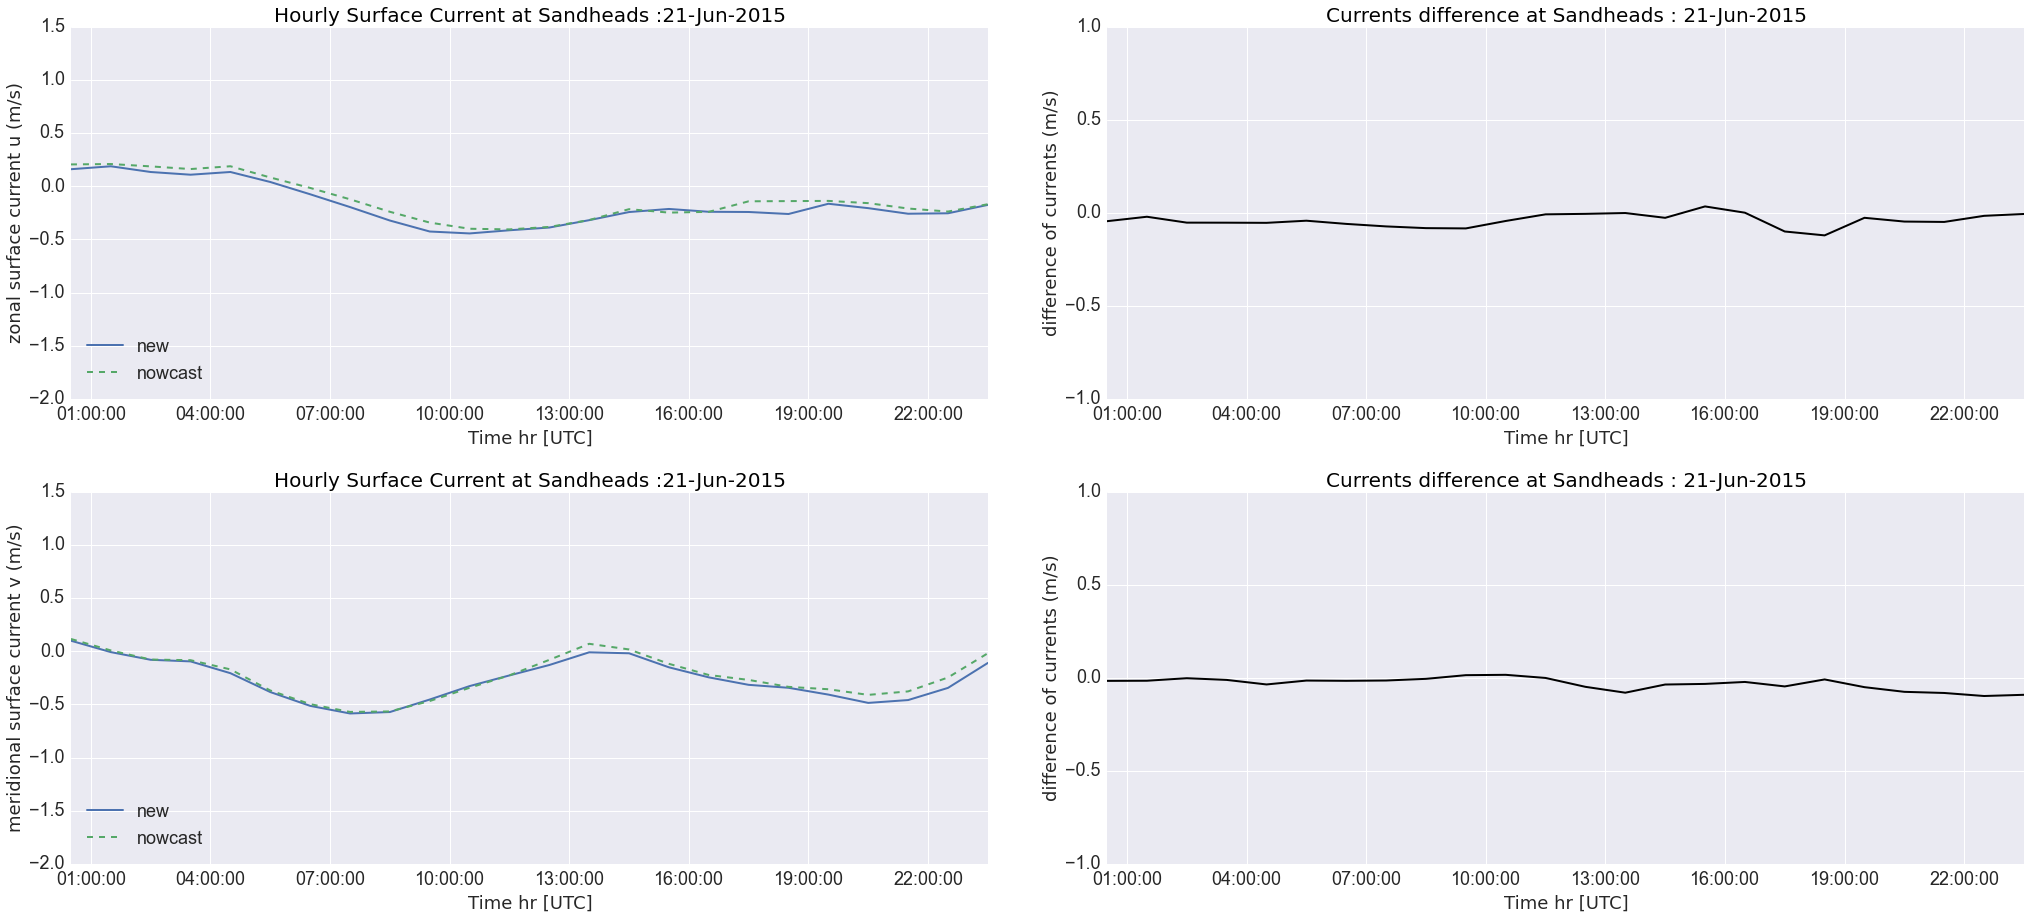

In [60]:
fig = compare_surfacecurrent_new(grid_T_21, 0, u_21mynow, v_21mynow, u_21now, v_21now)

* For June 22

In [61]:
grid_U_mynow22 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150622_20150622_grid_U.nc')
grid_V_mynow22 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150622_20150622_grid_V.nc')
u_22mynow = grid_U_mynow22.variables['vozocrtx']
v_22mynow = grid_V_mynow22.variables['vomecrty']

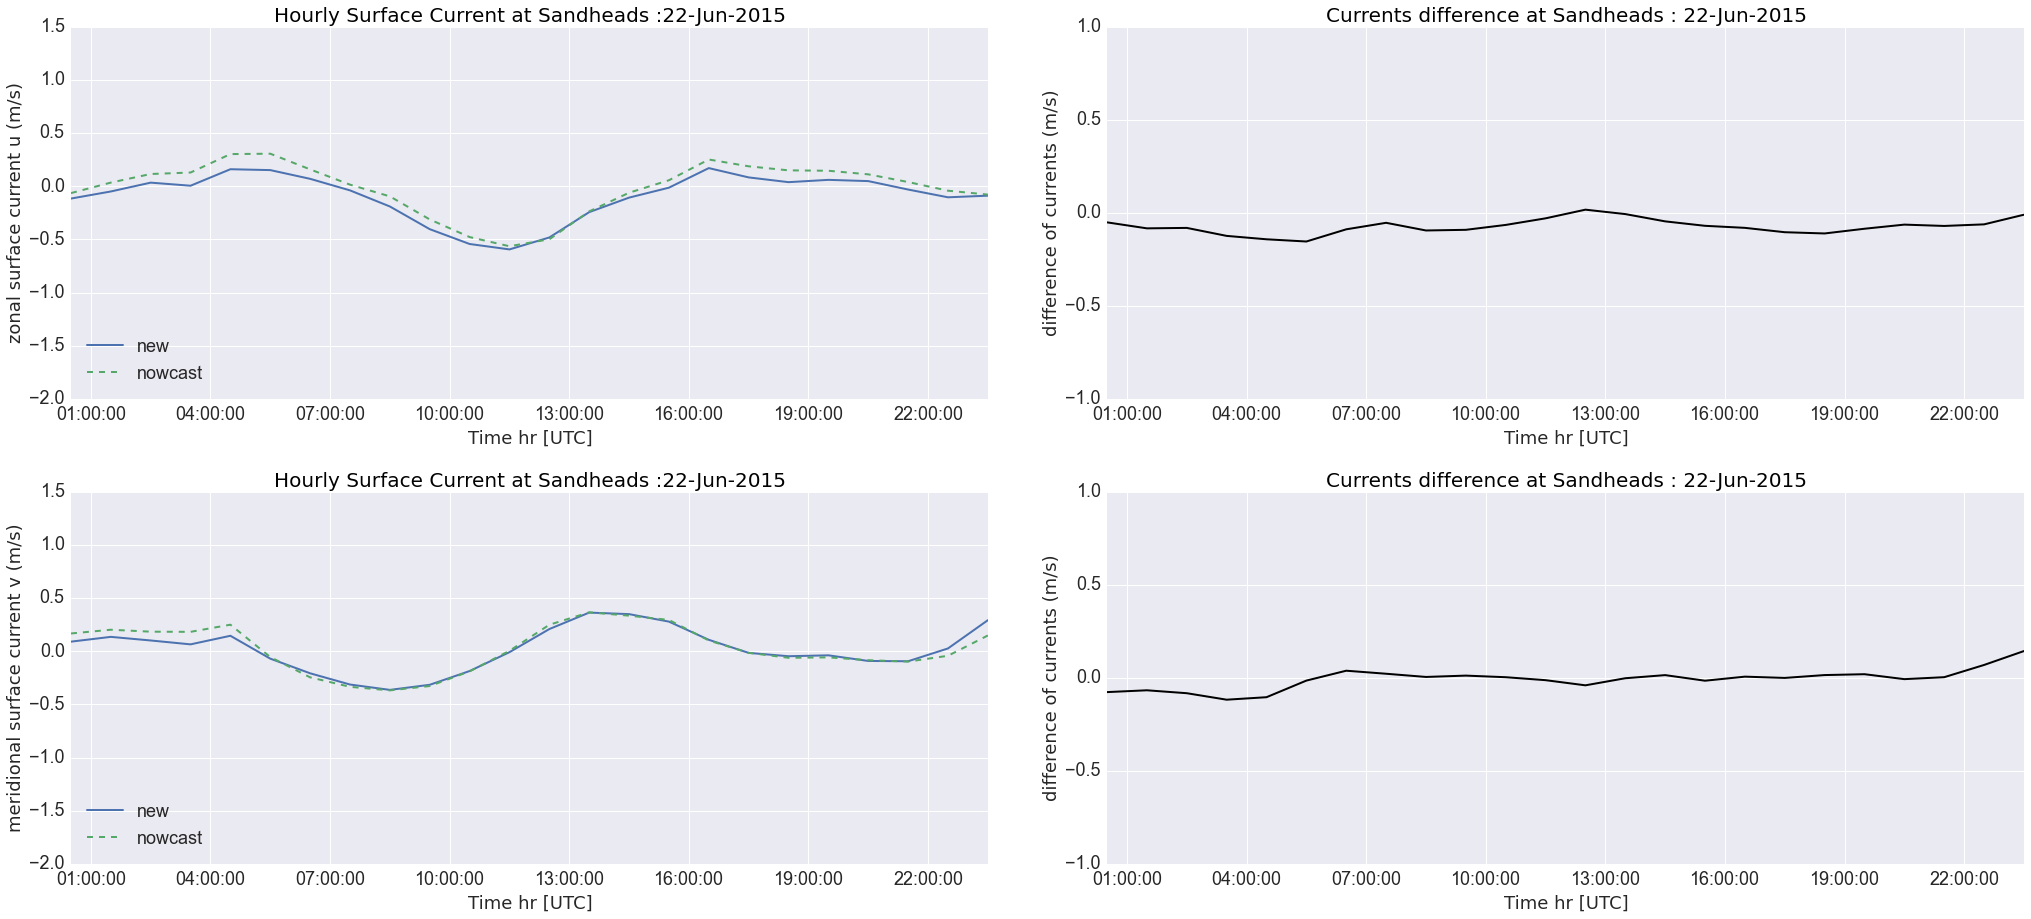

In [62]:
fig = compare_surfacecurrent_new(grid_T_22, 0, u_22mynow, v_22mynow, u_22now, v_22now)

* For June 23

In [63]:
grid_U_mynow23 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150623_20150623_grid_U.nc')
grid_V_mynow23 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150623_20150623_grid_V.nc')
u_23mynow = grid_U_mynow23.variables['vozocrtx']
v_23mynow = grid_V_mynow23.variables['vomecrty']

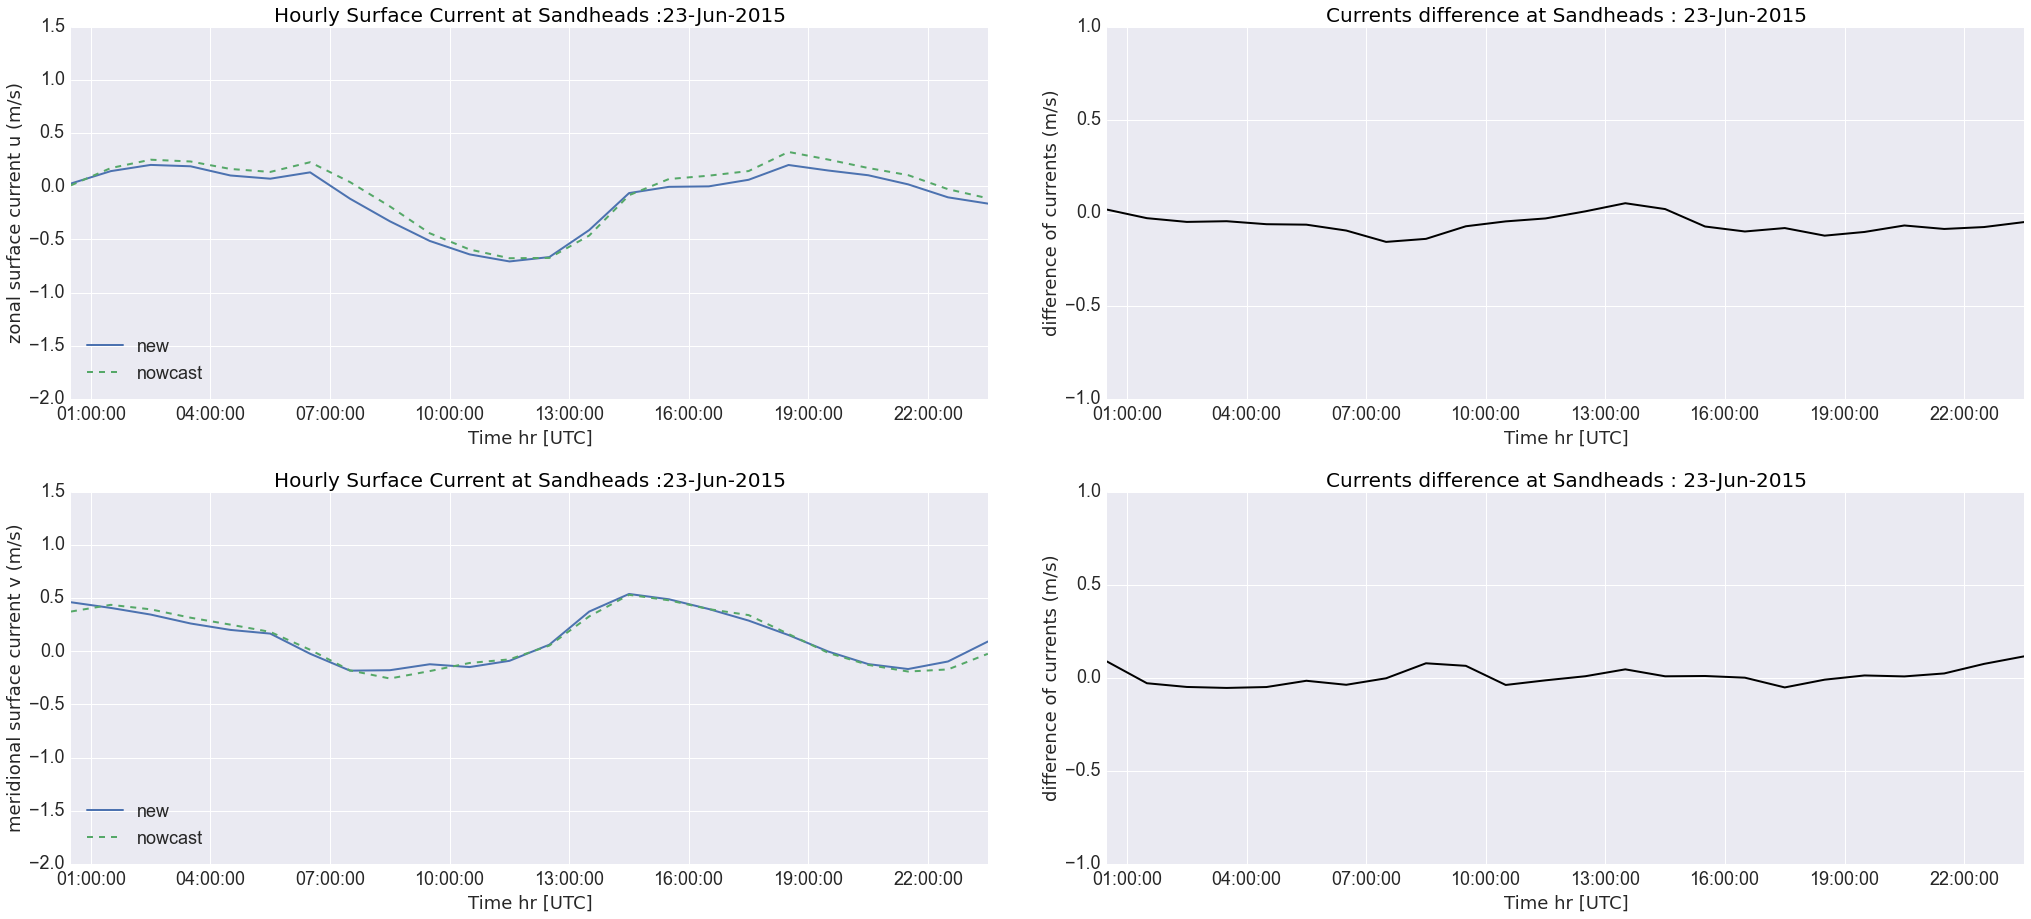

In [64]:
fig = compare_surfacecurrent_new(grid_T_23, 0, u_23mynow, v_23mynow, u_23now, v_23now)

* For June 24

In [65]:
grid_U_mynow24 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150624_20150624_grid_U.nc')
grid_V_mynow24 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150624_20150624_grid_V.nc')
u_24mynow = grid_U_mynow24.variables['vozocrtx']
v_24mynow = grid_V_mynow24.variables['vomecrty']

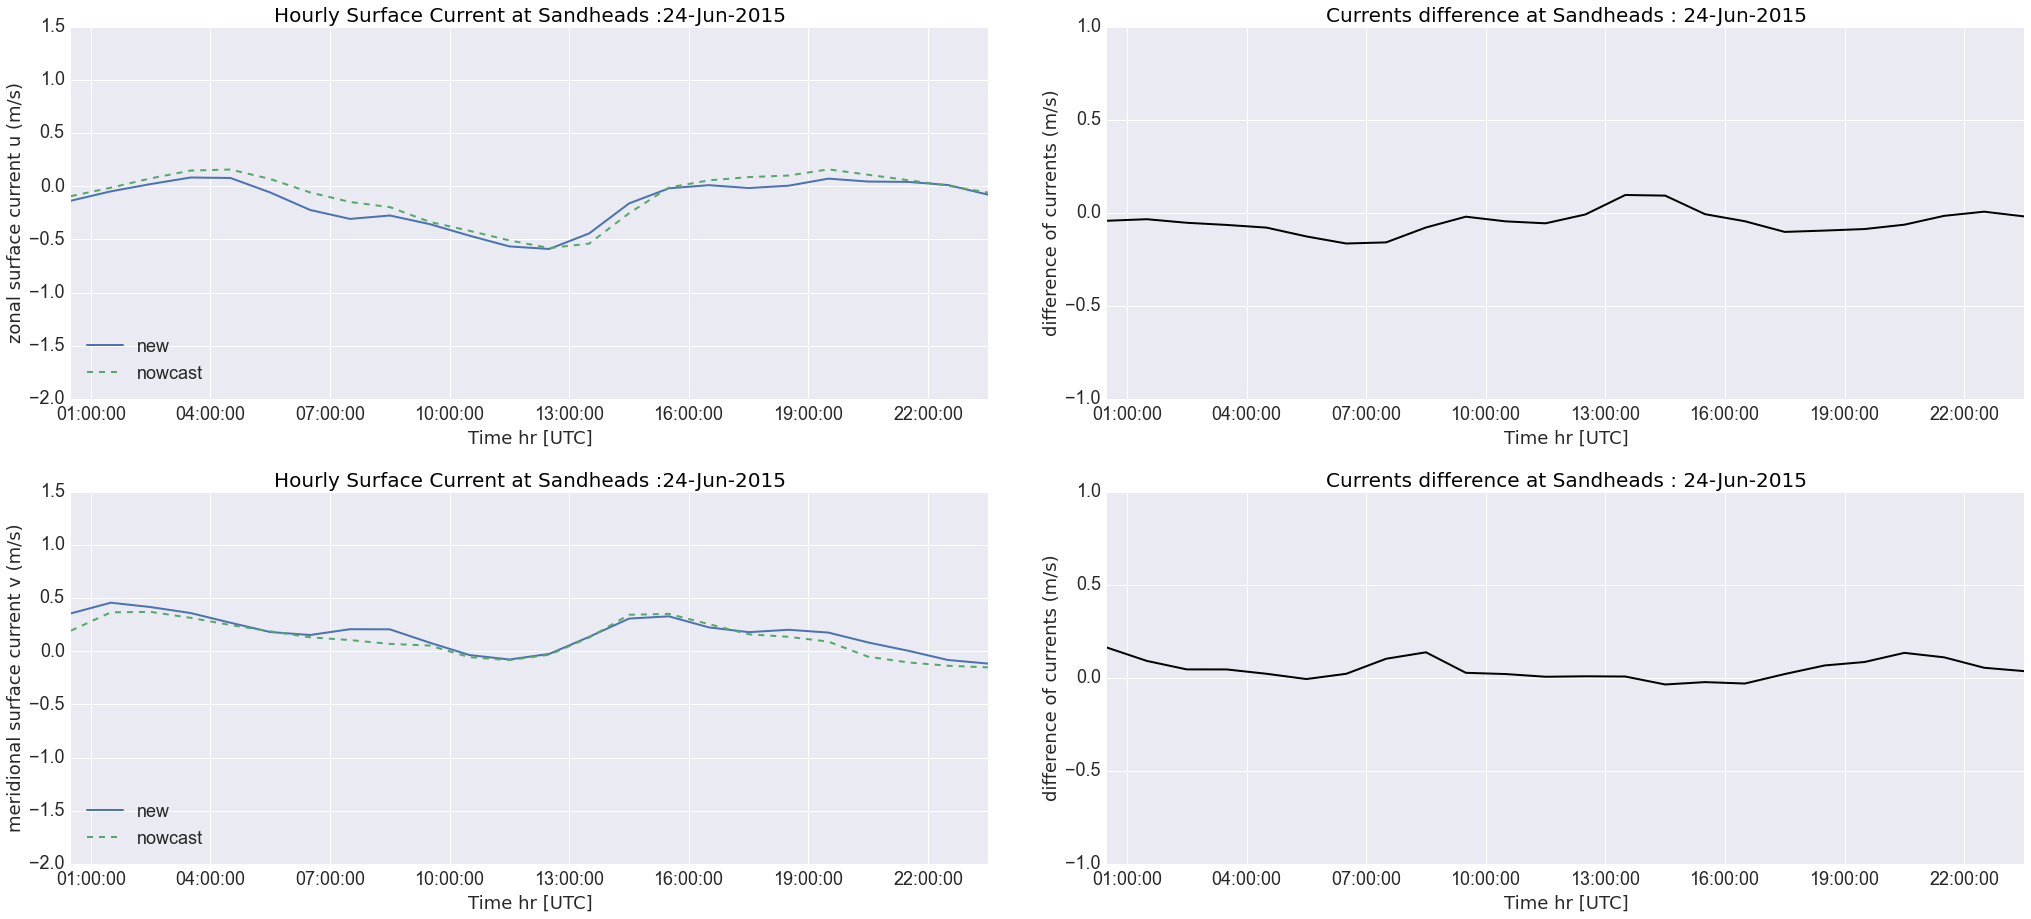

In [66]:
fig = compare_surfacecurrent_new(grid_T_24, 0, u_24mynow, v_24mynow, u_24now, v_24now)

* For June 25

In [67]:
grid_U_mynow25 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150625_20150625_grid_U.nc')
grid_V_mynow25 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150625_20150625_grid_V.nc')
u_25mynow = grid_U_mynow25.variables['vozocrtx']
v_25mynow = grid_V_mynow25.variables['vomecrty']

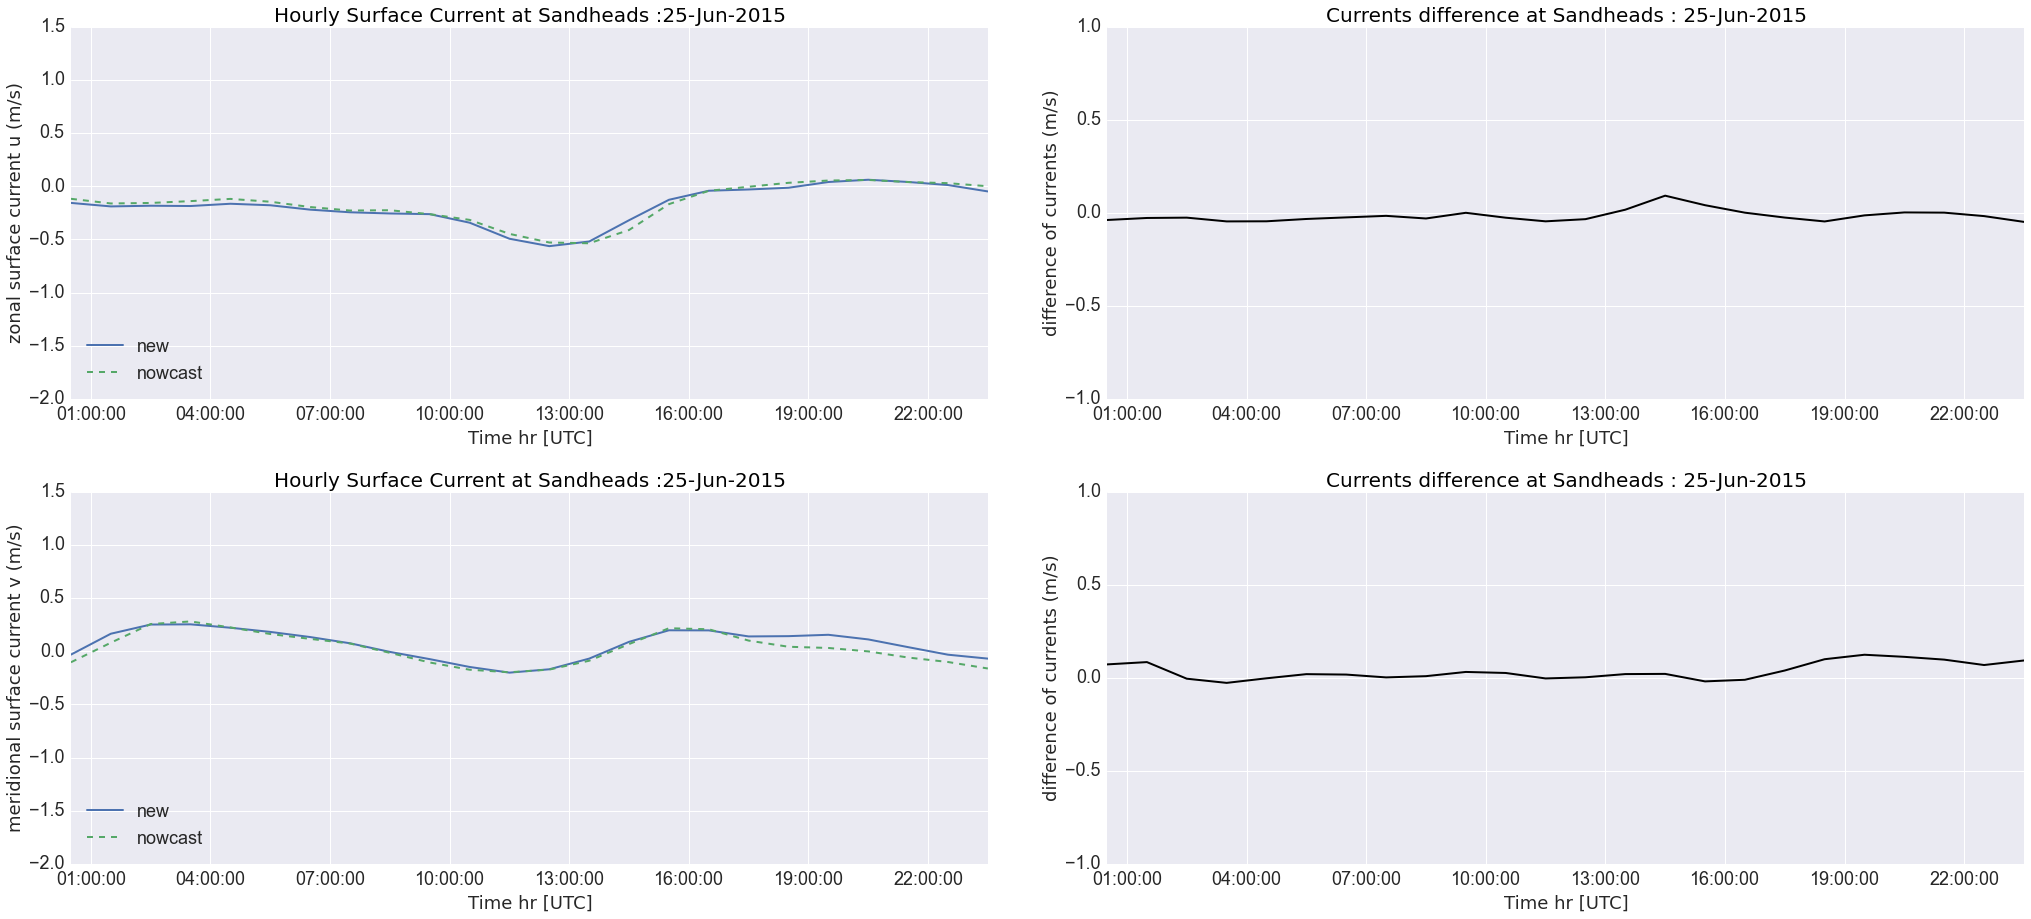

In [68]:
fig = compare_surfacecurrent_new(grid_T_25, 0, u_25mynow, v_25mynow, u_25now, v_25now)

* For June 26

In [69]:
grid_U_mynow26 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150626_20150626_grid_U.nc')
grid_V_mynow26 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150626_20150626_grid_V.nc')
u_26mynow = grid_U_mynow26.variables['vozocrtx']
v_26mynow = grid_V_mynow26.variables['vomecrty']

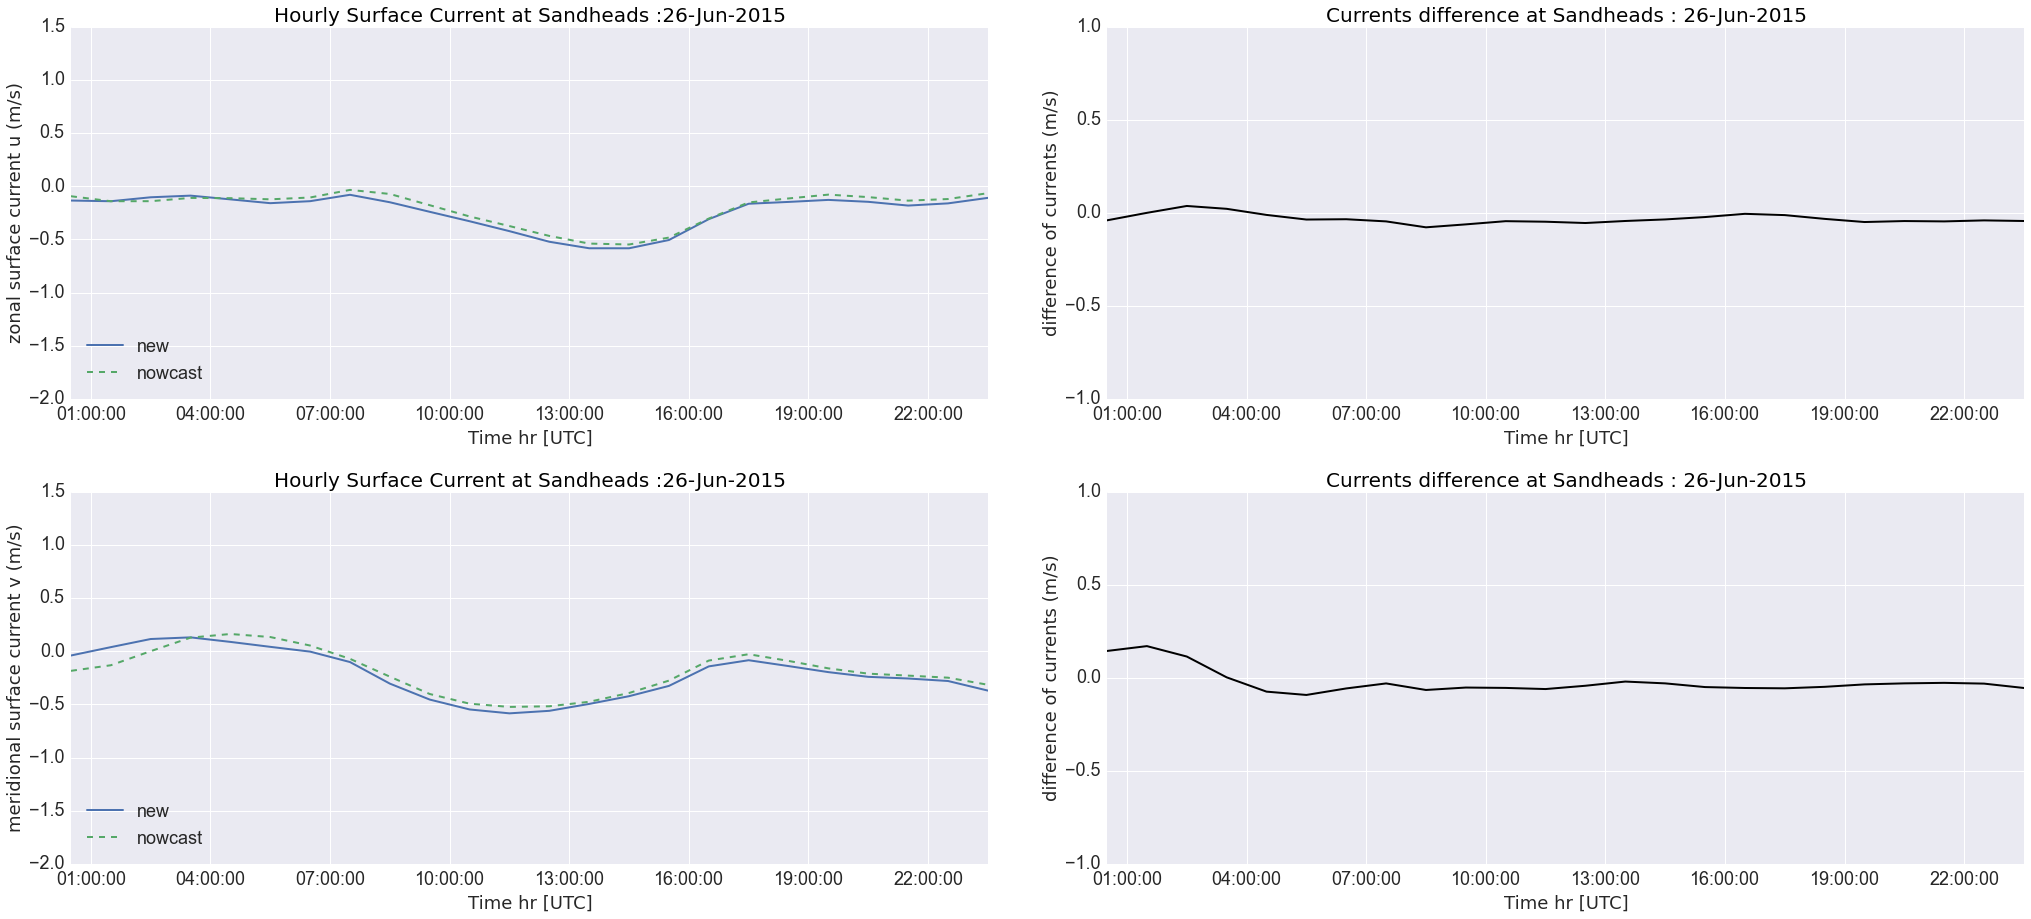

In [70]:
fig = compare_surfacecurrent_new(grid_T_26, 0, u_26mynow, v_26mynow, u_26now, v_26now)

* For June 27

In [71]:
grid_U_mynow27 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150627_20150627_grid_U.nc')
grid_V_mynow27 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150627_20150627_grid_V.nc')
u_27mynow = grid_U_mynow27.variables['vozocrtx']
v_27mynow = grid_V_mynow27.variables['vomecrty']

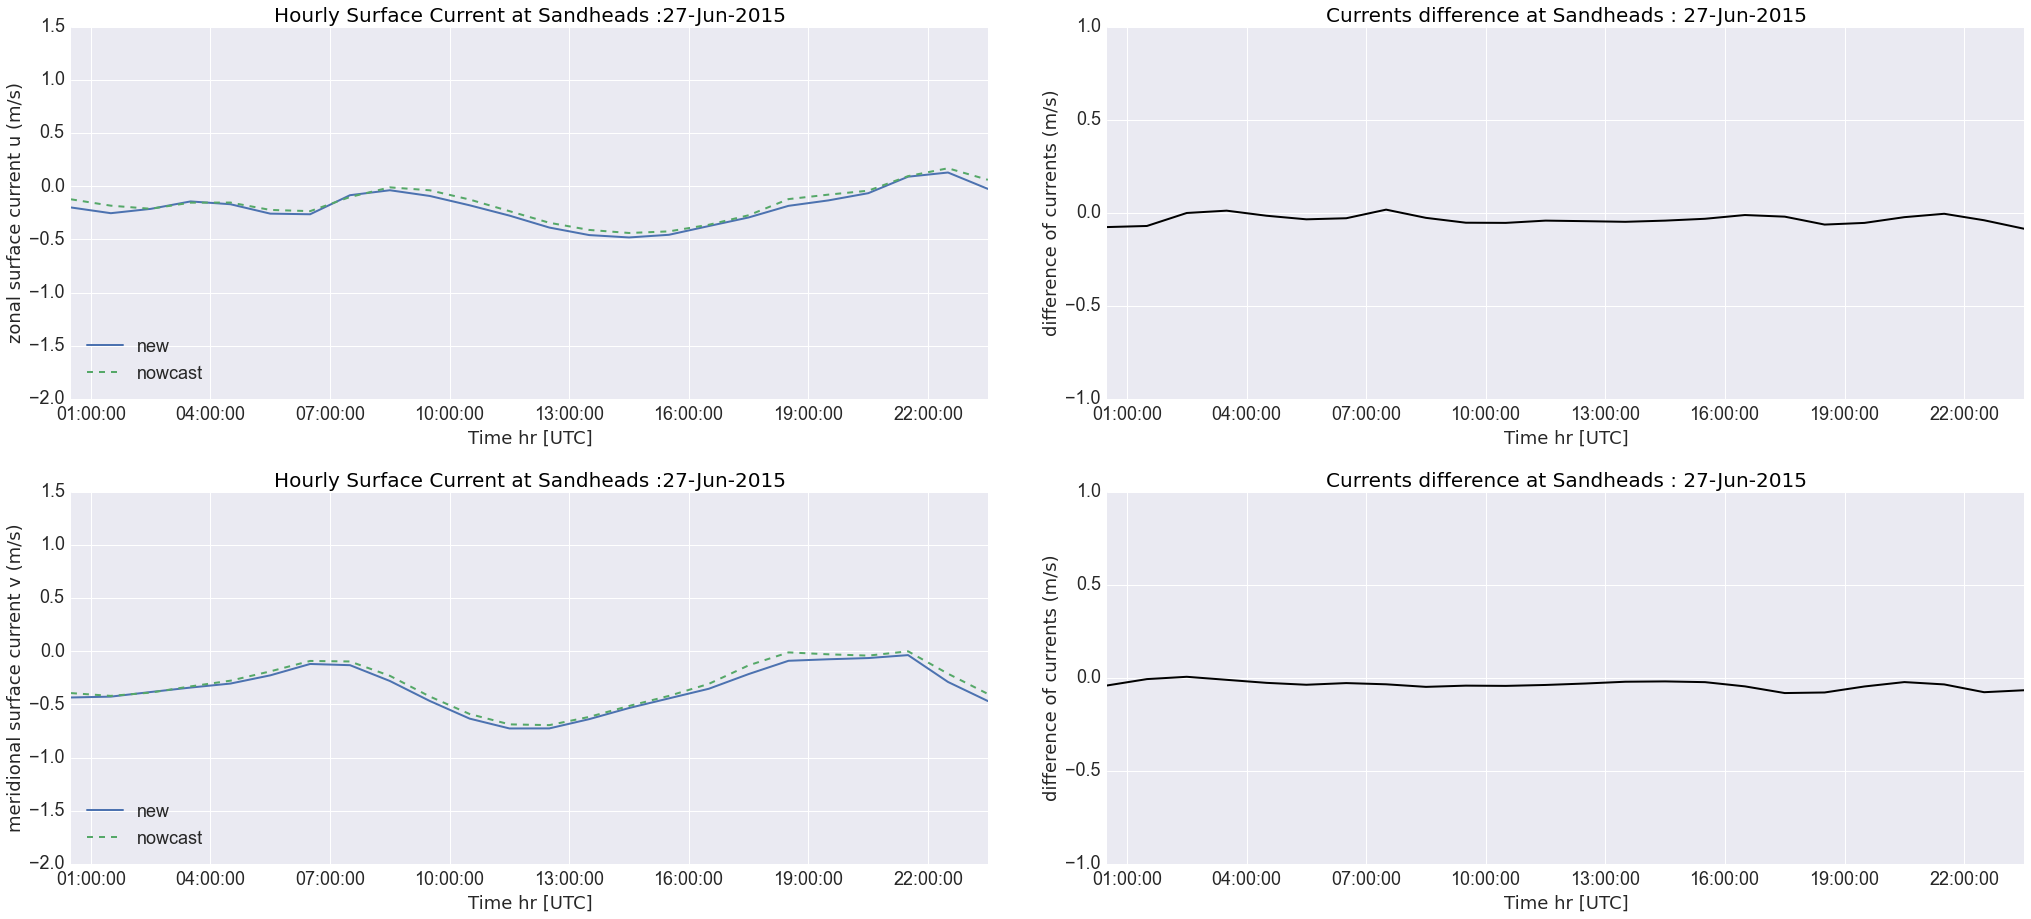

In [72]:
fig = compare_surfacecurrent_new(grid_T_27, 0, u_27mynow, v_27mynow, u_27now, v_27now)

* For June 28

In [73]:
grid_U_mynow28 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150628_20150628_grid_U.nc')
grid_V_mynow28 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150628_20150628_grid_V.nc')
u_28mynow = grid_U_mynow28.variables['vozocrtx']
v_28mynow = grid_V_mynow28.variables['vomecrty']

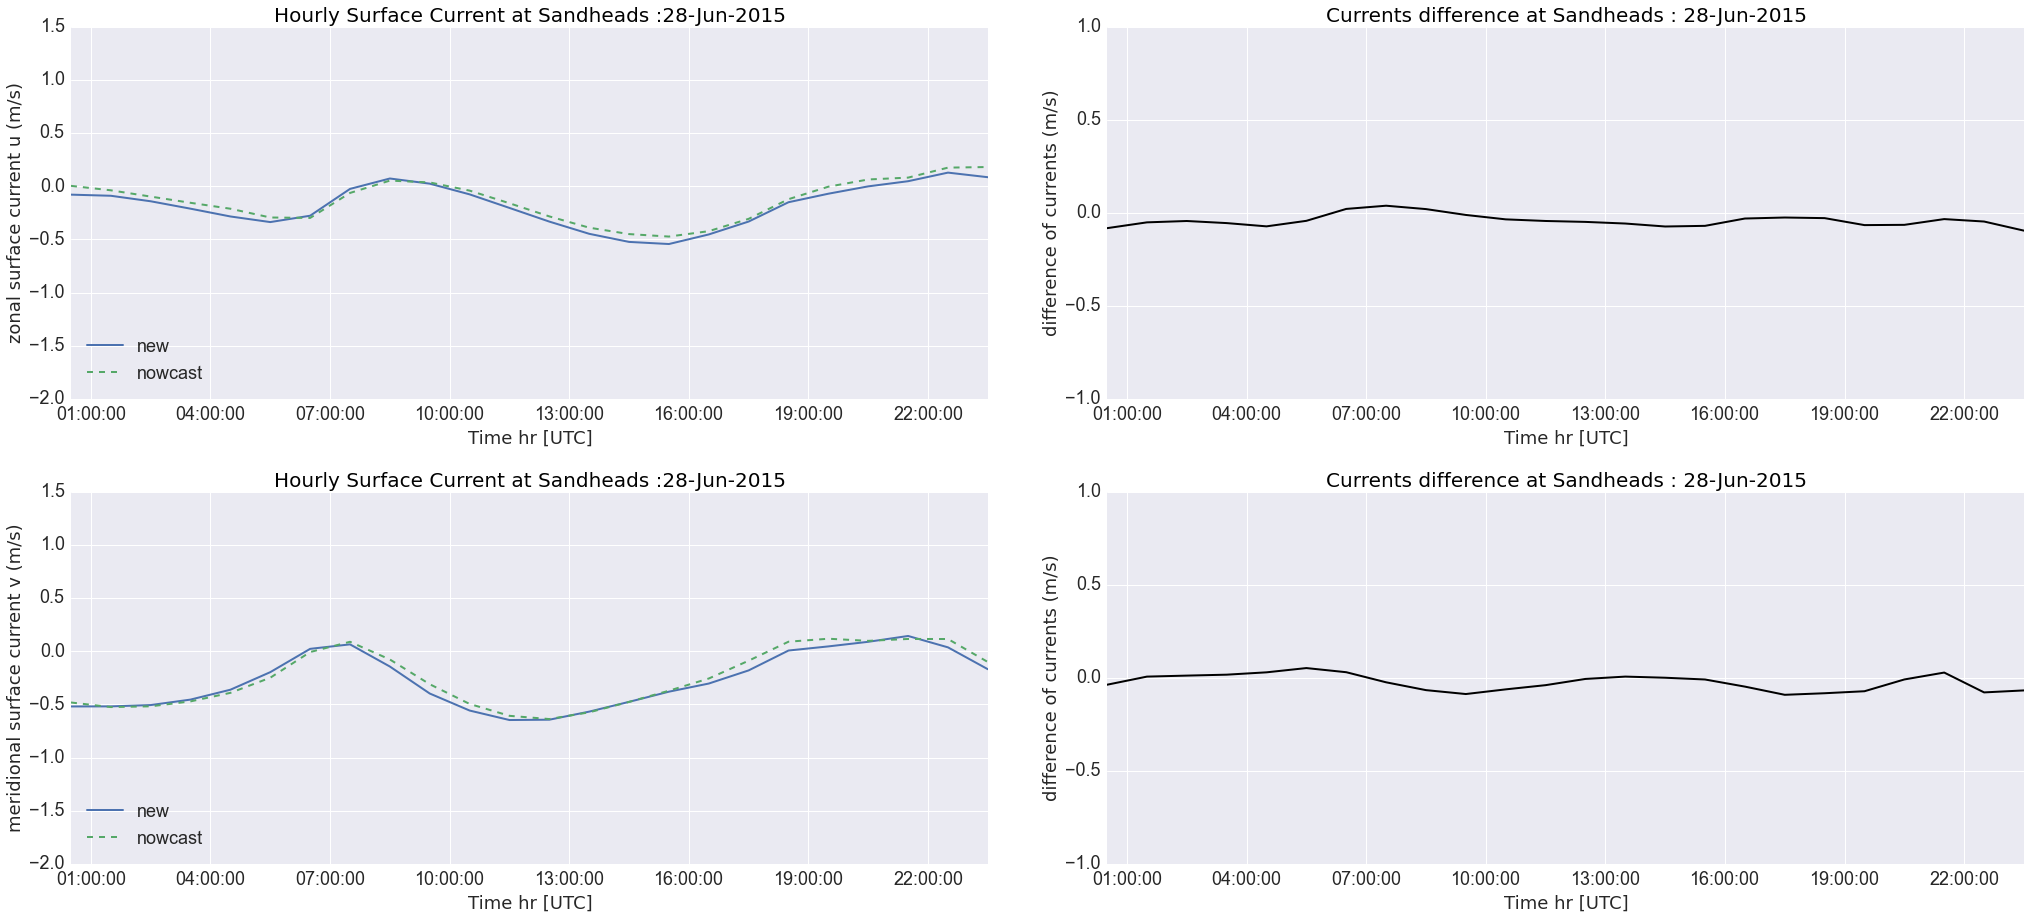

In [74]:
fig = compare_surfacecurrent_new(grid_T_28, 0, u_28mynow, v_28mynow, u_28now, v_28now)

* For June 29

In [75]:
grid_U_mynow29 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150629_20150629_grid_U.nc')
grid_V_mynow29 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast_20150629_20150629_grid_V.nc')
u_29mynow = grid_U_mynow29.variables['vozocrtx']
v_29mynow = grid_V_mynow29.variables['vomecrty']

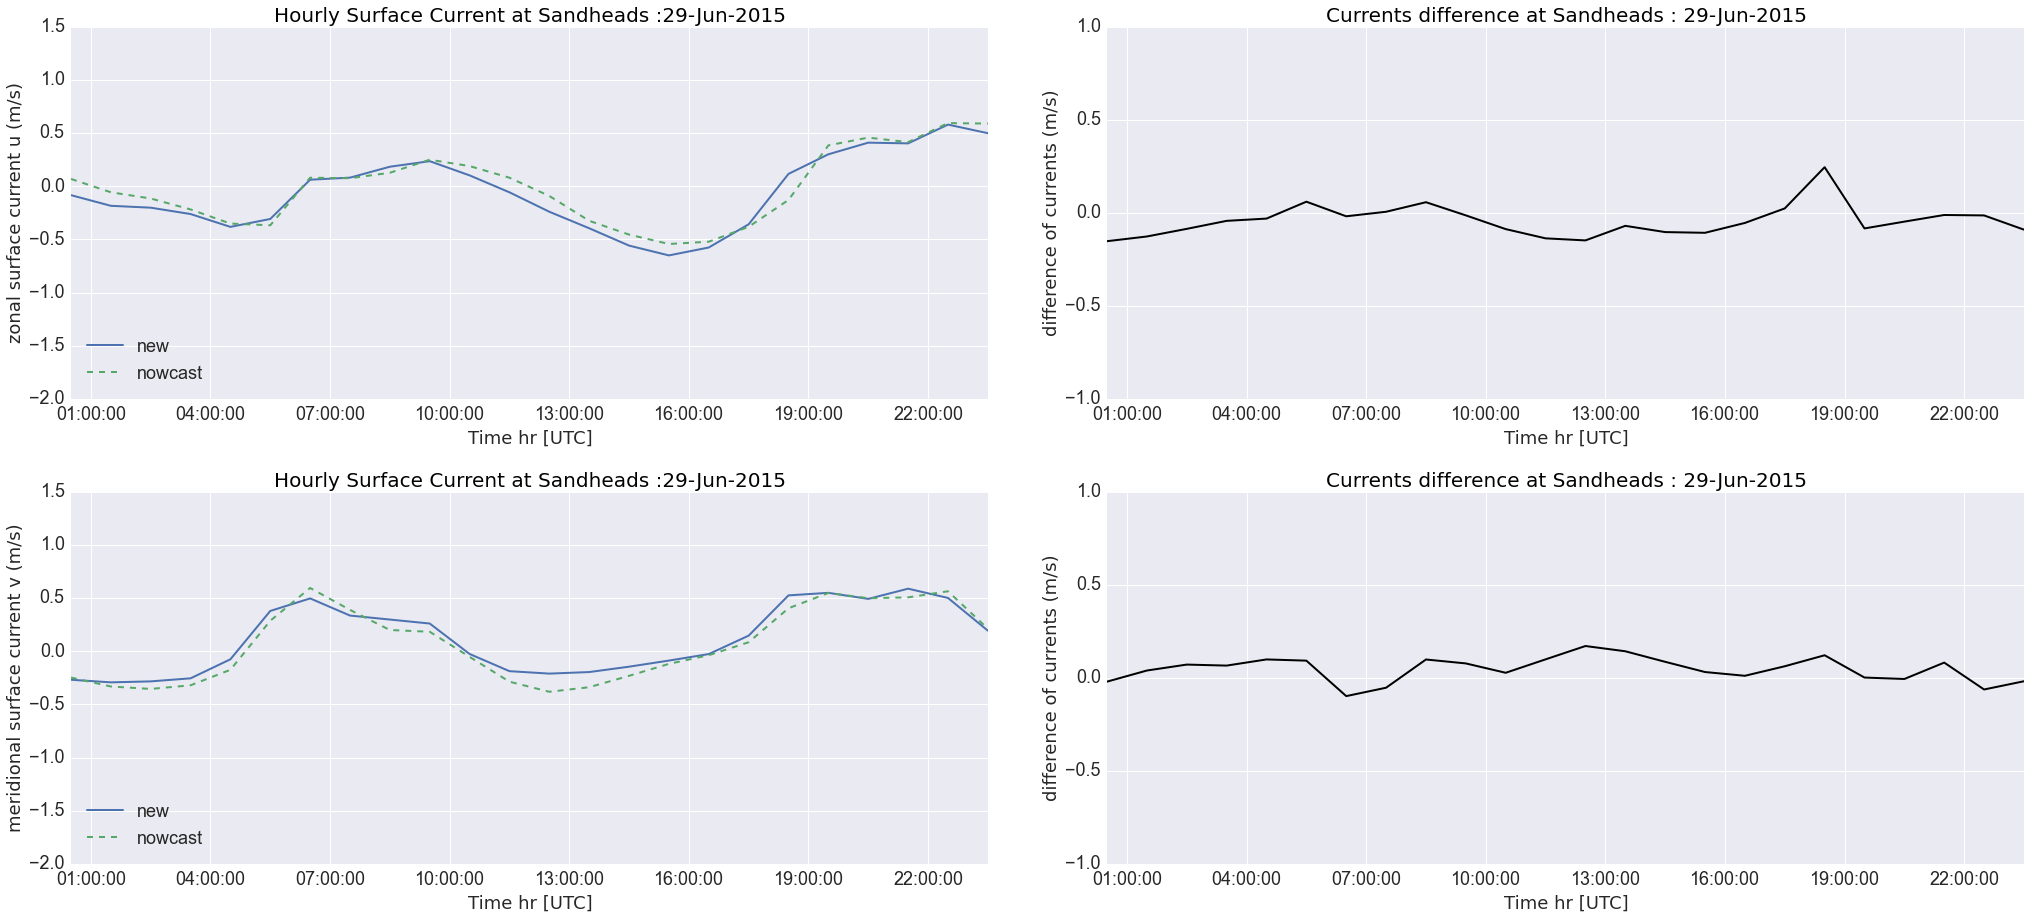

In [76]:
fig = compare_surfacecurrent_new(grid_T_29, 0, u_29mynow, v_29mynow, u_29now, v_29now)

* Currents discrepency in June 27 is the smallest from the above comparisons, 12 days after June 15.

#  Root Mean Square of both nowcasts with Doug's and mine

In [12]:
to = datetime.datetime(2015,6,16)
tf = datetime.datetime(2015,6,29)

#daily averages
files_U = analyze.get_filenames(to,tf,'1h','grid_U','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
u_daily, time_daily = analyze.combine_files(files_U, 'vozocrtx',0,\
                    sites['Sandheads']['i']+349,sites['Sandheads']['j'] + 259)
files_V = analyze.get_filenames(to,tf,'1h','grid_V','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
v_daily, time_daily = analyze.combine_files(files_V, 'vomecrty',0,\
                    sites['Sandheads']['i']+349,sites['Sandheads']['j'] + 259)

In [13]:
filess = analyze.get_filenames(to,tf,'1d','grid_T','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
none, time_dailyuse = analyze.combine_files(filess, 'vosaline',0,\
                    sites['Sandheads']['i']+349,sites['Sandheads']['j'] + 259)

In [20]:
def rms_bothnowcasts(u_daily,v_daily,time_dailyuse):
    """This function was made to calculate 
        root mean square of currents at Sandheads
        for nowcasts with Doug's and Mine"""
    grid_U = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast06160629gridU.nc')
    grid_V = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast/1hnowcast06160629gridV.nc')
    u = grid_U.variables['vozocrtx']
    v = grid_V.variables['vomecrty']
    u_mine = u[:, 0 ,sites['Sandheads']['i'], sites['Sandheads']['j']]
    v_mine = v[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']]
    
    add_doug = np.zeros(time_dailyuse.shape)
    add_mine = np.zeros(time_dailyuse.shape)
    add_relative=np.zeros(time_dailyuse.shape)
    rms_doug = np.zeros(time_dailyuse.shape)
    rms_mine = np.zeros(time_dailyuse.shape)
    rms_relative=np.zeros(time_dailyuse.shape)
    z= 0
    
    for i in np.arange(0, 336, 24):
        for j in np.arange(24):
            jj= i+j
            #u_doug[j] = sal_daily[jj]
            #v_doug[j] = sal_daily[jj]
            add_doug[z] = add_doug[z] + (u_daily[jj]**2 + v_daily[jj]**2)
            add_mine[z] = add_mine[z] + (u_mine[jj]**2 + v_mine[jj]**2)
            add_relative[z] = add_relative[z] + (u_mine[jj]-u_daily[jj])**2\
            +(v_mine[jj]-v_daily[jj])**2
            #addd[z]=addd[z] + (sal_daily[jj]**2 + sal_daily[jj]**2)
        z = z+1
    rms_doug[:] = np.sqrt(add_doug[:]/24)
    rms_mine[:] = np.sqrt(add_mine[:]/24)
    rms_relative[:] = np.sqrt(add_relative[:]/24)
    
    
    ## plot
    fig, axs = plt.subplots(2, 1, figsize=(15, 8)) 
    
    nowcast, = axs[0].plot(time_dailyuse, rms_doug, linewidth = 2,linestyle='--', marker = '*')
    my_nowcast, = axs[0].plot(time_dailyuse,rms_mine, linewidth = 2, marker='o')
    axs[0].grid('on')
    axs[0].set_ylim([0,1])
    axs[0].legend([nowcast,my_nowcast],['nowcast','my_nowcast'],loc = 2, fontsize =14)
    axs[0].set_ylabel('RMS', **axis_font)
    
    
    axs[1].plot(time_dailyuse, rms_relative, linewidth = 2, marker ='.', color ='indigo')
    axs[1].grid('on')
    axs[1].set_ylim([0,0.2])
    axs[1].set_ylabel('RMS', **axis_font)
    
    
    return fig

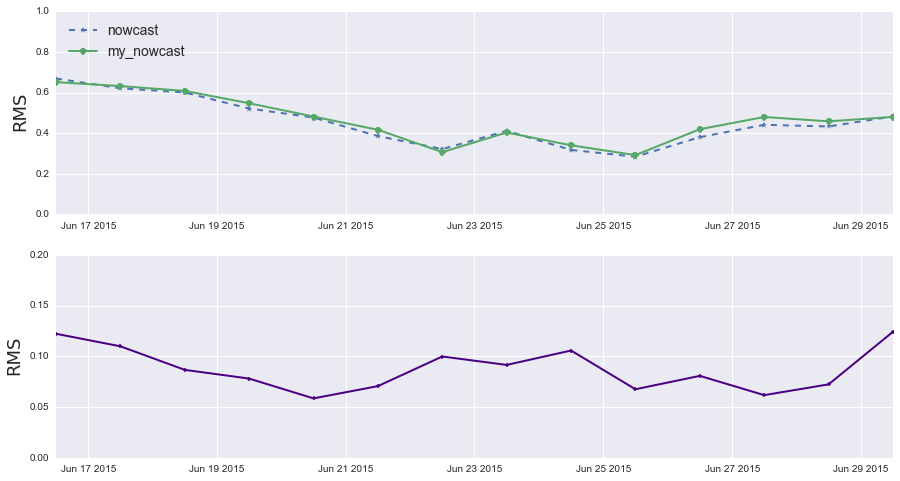

In [21]:
fig = rms_bothnowcasts(u_daily,v_daily,time_dailyuse)

In [19]:
fig.savefig('RMSseaborn.png')

* Lower panel is the rms between nowcasts and new results,sqrt((unew - nnow )^2 + (vnew -vnow)^2)). After June 27 the surface currents difference between nowcasts and new results is less than 0.2 and become more stable. 